# Lending Club Case Study








## Data Understanding

**Problem Statement:** Lending Club aims to mitigate the risk of loan defaults while maximizing the approval of profitable loans. We will employ data analysis techniques to pinpoint the factors strongly associated with default, aiding in better risk assessment for future loan decisions. 

**1.Data Overview**
* **Dataset:** Loan approval records, including borrower demographics, loan attributes, and repayment outcomes.
    * **Customer Demographics**
  * Annual Income (annual_inc) - Annual income of the customer. Generally higher the income, more chances of loan pass
  * Home Ownership (home_ownership) - Wether the customer owns a home or stays rented. Owning a home adds a collateral which increases the chances of loan pass.
  * Employment Length (emp_length) - Employment tenure of a customer (this is overall tenure). Higher the tenure, more financial stablity, thus higher chances of loan pass
  * Debt to Income (dti) - The percentage of the salary which goes towards paying loan. Lower DTI, higher the chances of a loan pass.
  * State (addr_state) - Location of the customer. Can be used to create a generic demographic analysis. There could be higher delinquency or defaulters demographicaly. 
* **Loan Attributes**
  *Loan Status* - Key Leading Attribute (*loan_status*). The column has three distinct values
    - Fully-Paid - The customer has successfuly paid the loan
    - Charged-Off - The customer is "Charged-Off" ir has "Defaulted"
    - Current - These customers, the loan is currently in progress and cannot contribute to conclusive evidence if the customer       will default or pay in future
  * Loan Ammount (loan_amt) 
  * Grade (grade)
  * Term (term)
  * Loan Date (issue_date)
  * Purpose of Loan (purpose)
  * Verification Status (verification_status)
  * Interest Rate (int_rate)
  * Installment (installment)
  * Public Records (public_rec) - Derogatory Public Records. The value adds to the risk to the loan. Higher the value, lower the success rate.
  * Public Records Bankruptcy  (public_rec_bankruptcy) - Number of bankruptcy records publically available for the customer. Higher the value, lower is the success rate.

* **Key Target Variable:** `loan_status` with an emphasis on "Charged-Off" (default) cases.

**2. Row Filtering:**

* Remove rows where `loan_status='Current'` as the outcome is inconclusive.

**3. Missing Data:**

* **Columns (65%+ missing):**  Drop columns exceeding this threshold to avoid excessive imputation. 
* **Drop columns `(id, member_id)`** as they are **index variables and have unique values** and dont contribute to the analysis
* **Drop columns `(emp_title, desc, title)`** as they are **discriptive and text (nouns) and dont contribute to analysis**
* **Drop redundant columns `(url)`**. url is a static path with the loan id appended as query. It's a redundant column to `(id)` column
* **Drop customer behaviour columns which represent data post the approval of loan** 
    - They contribute to the behaviour of the customer. Behaviour of the customer is recorded post approval of loan and not available at the time of loan approval. Thus these variables will not be considered in analysis and thus dropped
    - `(delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, application_type)`
* **Rows (5%+ missing):** Drop rows. 
* **Imputation:**  Use mean/median imputation for columns with lower missing data percentages. Consider more sophisticated methods if predictive relationships are evident.

**4. Outlier Treatment:**

* Carefully examine outliers in key numerical features (e.g., `loan_amnt`, `annual_inc`, `int_rate`). 
* Employ a strategy of winsorization or percentile-capping for most cases. Remove  only extreme outliers  where values are likely data errors.

**5. Data Transformations:**

* **Text Cleaning:** Standardize capitalization and address potential typos in categorical columns. 
* **Date Conversion:**  Convert `issue_d` to datetime format for temporal analysis.
* **Numerical Encoding:** Clean up `int_rate` (remove '%'), and ensure consistent numerical types across relevant columns. 

#### Convert Column Format
- `(loan_amnt, funded_amnt, funded_amnt_inv)` columns are Object and will be converted to float
- `(int_rate, installment, dti)` columns are Object and will be converted to float
- **strip "month"** text from `term` column and convert to integer
- Percentage columns `(int_rate)` are object. **Strip "%"** characters and convert column to float
- `issue_d` column **converted to datetime format**

#### Standardise Values
- All currency columns are rounded off to 2 decimal places as currency are limited to cents/paise etc only.

#### Convert Column Values
- `emp_length` converted to integer with following logic. Note < 1 year is converted to zero and 10+ converted to 10.
    - < 1 year: 0,  
    - 2 years: 2,  
    - 3 years: 3,  
    - 7 years: 7,  
    - 4 years: 4,
    - 5 years: 5,
    - 1 year: 1,
    - 6 years: 6,
    - 8 years: 8,
    - 9 years: 9,
    - 10+ years: 10

#### Creating derived columns
- issue_y is year extracted from issue_d
- issue_m is month extracted from issue_d

### Column Dropping Rules
- Approach taken here in this analysis, if total number of rows (for all columns) which are blank is less than 5% of the dataset, we are dropping the rows. If the total rows are greater than 5% we will impute
- If the dataset of blanks is considerably small, dropping the rows will possible be more accurate approach withoug impacting the dataset and the outcomes
- If the dataset of blanks are considerably large, dropping the rows will skew the analysis and impute approach will be taken
- In the current dataset, combined row count of blanks for `emp_length` and `pub_rec_bankruptcies` is 1730, which is 4.48% of the total rows thus dropping the rows will be the more accurate approach


### Outlier Treatment Rules
- Approach taken in this analysis to drop all outlier rows
- The following columns were evaluated for outliers `loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti`
- Total rows dropped due to outlier treatment:  3791
- Percentage of rows dropped due to outlier treatment:  10.29 %


## Data Cleaning and Manipulation


### Imports and Initial Setup

In [1]:
# Importing core libraries required for the case study
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sea
import datetime as dt
import warnings

pd.set_option('display.max_rows', None)     # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_colwidth', 25) # Set the maximum column width

# Suppress warnings
warnings.filterwarnings('ignore')

### Loading Data

In [2]:
loandf=pd.read_csv("loan.csv")
loandf.head()


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.c...,Borrower added on 1...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.c...,Borrower added on 1...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.c...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.c...,Borrower added on 1...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year

### Data Dictionary 

In [3]:
# Loading all data dictionary values
dict_data = pd.read_excel('Data_Dictionary.xlsx')
pd.set_option('display.max_colwidth', 200)
dict_data.dropna(subset=['LoanStatNew'], inplace=True)
selected_data = dict_data[['LoanStatNew', 'Description']]
selected_data

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [4]:
pd.set_option('display.max_colwidth', 25)

In [5]:
loandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [6]:
loandf.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
loandf.shape

(39717, 111)

**Checking Percentage of Missing Values**
1. **Ensures data quality and integrity**: Verifies that data is accurate and reliable.
2. **Identifies potential biases**: Reveals missing values that could skew analysis and modeling results.
3. **Determines need for data imputation or interpolation**: Indicates whether missing values need to be filled or estimated.
4. **Avoids reduced performance**: Prevents missing values can impact negatively .
5. **Reduces risk of overfitting or underfitting**: Ensures that models are trained on complete and representative data.
6. **Informs data preprocessing and feature engineering decisions**: Guides choices about handling missing values and data preparation.
7. **Helps meet data quality thresholds**: Ensures that missing values are within acceptable limits (e.g., <5%, 5-10%, >10%).

In [8]:
# percentage of nulls by column
#100*loandf.isnull().mean()
percentage_missing = (loandf.isnull().sum() / len(loandf)) * 100
percentage_missing_sorted = percentage_missing.sort_values(ascending=False)
percentage_missing_sorted

verification_status_joint         100.000000
annual_inc_joint                  100.000000
mo_sin_old_rev_tl_op              100.000000
mo_sin_old_il_acct                100.000000
bc_util                           100.000000
bc_open_to_buy                    100.000000
avg_cur_bal                       100.000000
acc_open_past_24mths              100.000000
inq_last_12m                      100.000000
total_cu_tl                       100.000000
inq_fi                            100.000000
total_rev_hi_lim                  100.000000
all_util                          100.000000
max_bal_bc                        100.000000
open_rv_24m                       100.000000
open_rv_12m                       100.000000
il_util                           100.000000
total_bal_il                      100.000000
mths_since_rcnt_il                100.000000
open_il_24m                       100.000000
open_il_12m                       100.000000
open_il_6m                        100.000000
open_acc_6

### Dropping Rows

**Dropping "Current" Loan Status Column**

* Focus on default risk: "Current" loans aren't in default, so they're not relevant.
* No default indicator: "Current" status doesn't provide info on default risk.
* Simplification: Dropping "Current" simplifies analysis and reduces dimensionality.

In [9]:
## where loan_status = "Current"
loandf = loandf[loandf['loan_status'] != "Current"]

In [10]:
loandf.shape

(38577, 111)

### Dropping Columns

**Dropping `member_id` Column**
The `member_id` column is a unique identifier for each member, but it is redundant since we already have a unique `id` column.
Dropping `member_id` simplifies the dataset and reduces dimensionality, making it easier to analyze.

In [11]:
loandf.drop(['member_id'],  axis=1,inplace=True)

**Dropping Text Columns (`url`, `emp_title`, `desc`, `title`)**

These columns contain text data, which is not directly relevant to the analysis of loan defaults.

In [12]:
loandf.drop(['url', 'emp_title', 'desc', 'title'],  axis=1,inplace=True)

**Dropping column sub_grade as the current analysis will limit to Grade only**

In [13]:
loandf.drop(['sub_grade'],  axis=1 , inplace=True)

Dropping all columns which refer to behavoural data of customer post loan approval

Behaviour data of the customers are captured post the loan approval

The data is not available at the time of loan approval and thus cannot be used for calculations

In [14]:
loandf.drop(['delinq_2yrs', 'earliest_cr_line', 
                          'inq_last_6mths', 'open_acc', 'pub_rec', 
                          'revol_bal', 'revol_util', 'total_acc', 
                          'total_pymnt', 
                          'total_pymnt_inv', 'total_rec_prncp', 
                          'total_rec_int', 'total_rec_late_fee', 'recoveries', 
                          'collection_recovery_fee', 'last_pymnt_d', 
                          'last_pymnt_amnt', 'last_credit_pull_d' 
                          ],  axis=1, inplace=True)

**Dropping Columns with All Missing Values**
Columns with all missing values do not provide any meaningful information for analysis .
Retaining such columns can lead to:
* **Increased dimensionality**, making analysis  more complex
* **Potential bias in models** due to incomplete data
* **Reduced interpretability of results**
Dropping columns with all missing values:
* **Simplifies the dataset** and reduces dimensionality
* **Avoids potential biases and errors** in analysis
By dropping columns with all missing values, we create a more robust and efficient dataset for analysis.

**Total columns with values NA**

In [15]:
len(loandf.columns[loandf.isna().all()].tolist())

55

**Columns Names with all values as NA**

In [16]:
loandf.columns[loandf.isna().all()].tolist()

['next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tot_hi_cred_

**Dropping all the columns whose all the records are NaN or Null**

In [17]:
loandf = loandf.dropna(axis='columns', how="all")

In [18]:
# Dropping all columns with all zero values
loandf = loandf.loc[:, (loandf != 0).any(axis=0)]

In [19]:
# Function to Drop all columns who have constant values (ignoring NA value)
# Example most of the columns is 1 and rest is NA, the column will be dropped
# If we have 1,2 and NA, the column wont be dropped
print("Columns with constant values with or without NA")
def drop_constant_columns(df):
    for c in df.columns:
        if df[c].nunique(dropna=True) == 1:
            print(c)
            df = df.drop(c, axis=1)
    return df

# Drop all constant columns from df1 (definition of constant is constant value across the rows, this ignores Na values)
loandf = drop_constant_columns(loandf)

Columns with constant values with or without NA
pymnt_plan
initial_list_status
collections_12_mths_ex_med
policy_code
application_type
chargeoff_within_12_mths
tax_liens


In [20]:
# Function which checks the amount of empty values in a dataframe and 
# drops the column if the amount of empty values is more than 65%

print("Columns with more that 65% empty records")
def drop_mostly_empty_columns(df):
    total_rows = len(df)
    for c in df.columns:
        # Drop columns whose mean na values exceed 65%
        if df[c].isna().mean().round(2) >= 0.65:
            print(c)
            df = df.drop(c, axis=1)
    return df
loandf = drop_mostly_empty_columns(loandf)

Columns with more that 65% empty records
mths_since_last_delinq
mths_since_last_record


### Data Conversion

In [21]:
# Convert the columns loan_amnt and funded_amnt as flot64
loandf = loandf.astype({'loan_amnt':'float','funded_amnt':'float'})

In [22]:
# Convert the term column into an integer from a string
loandf['term'] = loandf['term'].apply(lambda x : int(x[:-7]))

In [23]:
# Convert int_rate to  float by removing the "%" character
loandf['int_rate'] = loandf['int_rate'].apply(lambda x : float(x[:-1]))

In [24]:
# Round off the values of key float fields to 2 decimal place
print("Rounding columns to 2 decimal places")
for c in ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'dti']:
    print(c)
    loandf[c] = loandf[c].apply(lambda x: round(x,2))

Rounding columns to 2 decimal places
loan_amnt
funded_amnt
funded_amnt_inv
int_rate
dti


In [25]:
# Converting the column issue_d from string object to DateTime
loandf['issue_d'] = pd.to_datetime(loandf['issue_d'], format='%b-%y')

### Imputing vs Dropping Columns

Evaluating the percentage of rows with blank values for both the columns. If the total percentage is less than 5% will take an option of dropping the columns vs imputing.

In [26]:
# Identify columns who have blank values and what percentage of total values are there blanks. 
# These values may need to be imputed
print('emp_length blank rows', loandf['emp_length'].isna().sum())
print('pub_rec_bankruptcies blank rows', loandf['pub_rec_bankruptcies'].isna().sum(), "\n")
imp_total = 0
for c in loandf.columns[loandf.isna().any()].tolist():
    imp_val = len(loandf[loandf[c].isna()]) / len(loandf) * 100
    imp_total += imp_val
    print(c, round(imp_val, 2),"%")
print("\nTotal rows percentage whose columns are blank: ", round(imp_total ,2), "%")

emp_length blank rows 1033
pub_rec_bankruptcies blank rows 697 

emp_length 2.68 %
pub_rec_bankruptcies 1.81 %

Total rows percentage whose columns are blank:  4.48 %


In [27]:
# Converting emp_length to integer values
# Converting emp_length as numerical data to create more effective statistical analysis as compared to nominal values
loandf['emp_length'] = loandf['emp_length'].replace({'< 1 year': 0, '2 years': 2, '3 years': 3, 
                                                         '7 years': 7, '4 years': 4, '5 years': 5, 
                                                         '1 year': 1, '6 years': 6, '8 years': 8, 
                                                         '9 years': 9,  '10+ years': 10})



In [28]:
# Print the current dimensions of the dataframe
rows_before = len(loandf)

In [29]:
# Drop rows with empty values in this scenario
# Since the percent of rows is very small, dropping the rows instead of imputing them
loandf = loandf[loandf['emp_length'].notna()]
loandf = loandf[loandf['pub_rec_bankruptcies'].notna()]

In [30]:
# Checking if blanks exist
loandf['emp_length'].value_counts()

emp_length
10.0    8369
0.0     4341
2.0     4207
3.0     3951
4.0     3297
5.0     3161
1.0     3077
6.0     2136
7.0     1689
8.0     1410
9.0     1209
Name: count, dtype: int64

In [31]:
# Print the dimensions of the dataframe after dropping rows
rows_after = len(loandf)
print("Number of rows dropped = ,", (rows_before - rows_after))
print("Percentage of rows dropped = ", round((rows_before - rows_after)/rows_before*100,2),"%")
print(loandf.shape)

Number of rows dropped = , 1730
Percentage of rows dropped =  4.48 %
(36847, 19)


In [32]:
# Printing column info to analyse missing values, empty values in a column
print(loandf.info())

<class 'pandas.core.frame.DataFrame'>
Index: 36847 entries, 0 to 39680
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    36847 non-null  int64         
 1   loan_amnt             36847 non-null  float64       
 2   funded_amnt           36847 non-null  float64       
 3   funded_amnt_inv       36847 non-null  float64       
 4   term                  36847 non-null  int64         
 5   int_rate              36847 non-null  float64       
 6   installment           36847 non-null  float64       
 7   grade                 36847 non-null  object        
 8   emp_length            36847 non-null  float64       
 9   home_ownership        36847 non-null  object        
 10  annual_inc            36847 non-null  float64       
 11  verification_status   36847 non-null  object        
 12  issue_d               36847 non-null  datetime64[ns]
 13  loan_status          

### Derived Columns

In [33]:
# Adding additional column for Year and Month for analysis extrating Year and Month from issue_d
loandf['issue_y'] = pd.DatetimeIndex(loandf['issue_d']).year
loandf['issue_m'] = pd.DatetimeIndex(loandf['issue_d']).month

In [34]:
# Bucketting Months to quarters
def bucket_issue_m(column):
    if column < 4:
        return 'Q1' 
    elif (column >= 4) and (column < 7):
        return 'Q2'      
    elif (column >= 7) and (column < 9):
        return 'Q3'  
    else:
        return 'Q4' # 75% quartile
    
loandf['issue_q'] = loandf.apply(lambda x : bucket_issue_m(x['issue_m']), axis = 1)

In [35]:
loandf['loan_amnt'].describe()

count    36847.000000
mean     11141.327652
std       7369.988994
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [36]:
# Bucketting Loan Amount
def bucket_loan_amnt(column):
    if column <= 5000:
        return '0 - 5K'  # 25% quartile
    elif (column >5000) and (column <= 10000):
        return '5K - 10K'      
    elif (column >10000) and (column <= 15000):
        return '10K - 15K'  
    else:
        return '15K - above' # 75% quartile
    
loandf['loan_amnt_b'] = loandf.apply(lambda x : bucket_loan_amnt(x['loan_amnt']), axis = 1)

In [37]:
loandf['annual_inc'].describe() / 1000

count      36.847000
mean       69.404482
std        64.027473
min         4.000000
25%        41.004000
50%        60.000000
75%        83.000000
max      6000.000000
Name: annual_inc, dtype: float64

In [38]:
# Bucketing Annual Income
def bucket_annual_inc(column):
    if column <= 40000:
        return '0 - 40k' # 25% quartile
    elif (column >40000) and (column <= 50000):
        return '40k - 50k'    
    elif (column >50000) and (column <= 60000):
        return '50k to 60k'
    elif (column >60000) and (column <= 70000):
        return '60k to 70k'
    elif (column >70000) and (column <= 80000):
        return '70k to 80k'
    else:
        return '80k - above' # 75% quartile

loandf['annual_inc_b'] = loandf.apply(lambda x: bucket_annual_inc(x['annual_inc']), axis = 1)

In [39]:
loandf['int_rate'].describe()

count    36847.000000
mean        11.988346
std          3.702091
min          5.420000
25%          8.940000
50%         11.860000
75%         14.520000
max         24.400000
Name: int_rate, dtype: float64

In [40]:
# Bucketing interest rate
def bucket_int_rate(column):
    if column <= 9:
        return 'Very Low' # 25% quartile
    elif (column >9) and (column <= 11):
        return 'Low'    
    elif (column >11) and (column <= 13):
        return 'Moderate'
    elif (column >13) and (column <= 15):
        return 'High'
    else:
        return 'Very High' # 75% quartile
    
loandf['int_rate_b'] = loandf.apply(lambda x : bucket_int_rate(x.int_rate), axis = 1)

In [41]:
loandf['dti'].describe()

count    36847.000000
mean        13.330449
std          6.651565
min          0.000000
25%          8.210000
50%         13.420000
75%         18.590000
max         29.990000
Name: dti, dtype: float64

In [42]:
# Bucketing dti
def bucket_dti(column):
    if column <= 8:
        return 'Very Low' # 25% quartile
    elif (column >8) and (column <= 12):
        return 'Low'    
    elif (column >12) and (column <= 16):
        return 'Moderate'
    elif (column >16) and (column <= 20):
        return 'High'
    else:
        return 'Very High' # 75% quartile
    
loandf['dti_b'] = loandf.apply(lambda x : bucket_dti(x.dti), axis = 1)

### Data Analysis Post Cleanup


In [43]:
# Printing column info to analyse missing values, empty values in a column
loandf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36847 entries, 0 to 39680
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    36847 non-null  int64         
 1   loan_amnt             36847 non-null  float64       
 2   funded_amnt           36847 non-null  float64       
 3   funded_amnt_inv       36847 non-null  float64       
 4   term                  36847 non-null  int64         
 5   int_rate              36847 non-null  float64       
 6   installment           36847 non-null  float64       
 7   grade                 36847 non-null  object        
 8   emp_length            36847 non-null  float64       
 9   home_ownership        36847 non-null  object        
 10  annual_inc            36847 non-null  float64       
 11  verification_status   36847 non-null  object        
 12  issue_d               36847 non-null  datetime64[ns]
 13  loan_status          

In [44]:
loandf.shape

(36847, 26)

In [45]:
loandf.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code',
       'addr_state', 'dti', 'pub_rec_bankruptcies', 'issue_y', 'issue_m',
       'issue_q', 'loan_amnt_b', 'annual_inc_b', 'int_rate_b', 'dti_b'],
      dtype='object')

**Listing all the Data Types in the cleaned Data**

In [46]:
loandf.dtypes

id                               int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                             int64
int_rate                       float64
installment                    float64
grade                           object
emp_length                     float64
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                 datetime64[ns]
loan_status                     object
purpose                         object
zip_code                        object
addr_state                      object
dti                            float64
pub_rec_bankruptcies           float64
issue_y                          int32
issue_m                          int32
issue_q                         object
loan_amnt_b                     object
annual_inc_b                    object
int_rate_b                      object
dti_b                    

## Outlier treatment

In [47]:
# This function creates a dictionary of outliers which includes the inter quartile range, 
# lower and upper bound for a particular column.
# Formulae used in this analysis
# IQR = 75th Quartile - 25th Quartile
# Lower Bound = 25th Quartile - 1.5 * IQR
# Upper Bound = 75th Quartile + 1.5 * IQR

iqr_multiplier = 1.5

def get_iqr(df, column):
    quar25 = df[column].quantile(0.25)
    quar75 = df[column].quantile(0.75)
    iqr = quar75 - quar25
    lower = quar25 - iqr_multiplier * iqr
    upper = quar75 + iqr_multiplier * iqr
    return {'quartile1': quar25, 'quartile3': quar75, 'iqr': iqr, 'lower_bound': lower, 'upper_bound': upper}


# The function treat outliers, prints a box plot for each column under consideration
# Plot 1 = Before outlier treatment
# Plot 2 = Post outlier treatment
# Also prints statistics of how many rows and percentage of rows dropped
def outlier_comparison(df, column):
    # box plot before dropping outliers
    fig, p = plot.subplots(1,2,figsize=(14, 3))
    splot1 = sea.boxplot(df[column], ax=p[0], orient="h")
    splot1.set_title('Plot ['+ column + '] - Original')
    new_df = df[df[column] < get_iqr(df, column)['upper_bound']]
    # box plot after dropping outliers    
    splot2 = sea.boxplot(new_df[column], ax=p[1], orient="h")
    splot2.set_title('Plot [' + column + '] - Post Outlier Treatment')
    plot.tight_layout()
    plot.show()
    
def drop_outlier(df, column):
    old_rows = len(df)
    new_df = df[df[column] < get_iqr(df, column)['upper_bound']]
    new_rows = len(new_df)
    print('Rows dropped: ', old_rows - new_rows)
    print('Percentage rows dropped: ', round((old_rows - new_rows)/old_rows*100,2), "%")
    return new_df


In [48]:
import seaborn as sea
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np

def get_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    return {'lower_bound': q1 - 1.5 * iqr, 'upper_bound': q3 + 1.5 * iqr}

def visualize_outliers(df, column):
    fig, p = plot.subplots(1, 2, figsize=(8, 4))
    sea.boxplot(df[column], ax=p[0], orient="h")
    p[0].set_title('Plot [' + column + '] - Original')
    new_df = df[(df[column] > get_iqr(df, column)['lower_bound']) & (df[column] < get_iqr(df, column)['upper_bound'])]
    sea.boxplot(new_df[column], ax=p[1], orient="h")
    p[1].set_title('Plot [' + column + '] - Post Outlier Treatment')
    plot.tight_layout()
    plot.show()

def remove_outliers(df, column):
    old_rows = len(df)
    iqr_bounds = get_iqr(df, column)
    new_df = df[(df[column] > iqr_bounds['lower_bound']) & (df[column] < iqr_bounds['upper_bound'])]
    new_rows = len(new_df)
    print('Rows dropped: ', old_rows - new_rows)
    print('Percentage rows dropped: ', round((old_rows - new_rows) / old_rows * 100, 2), "%")
    return new_df


original_row_count 36847


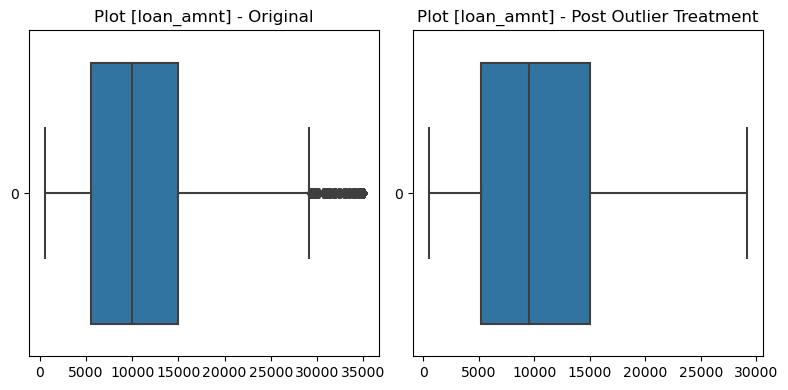

Rows dropped:  1078
Percentage rows dropped:  2.93 %


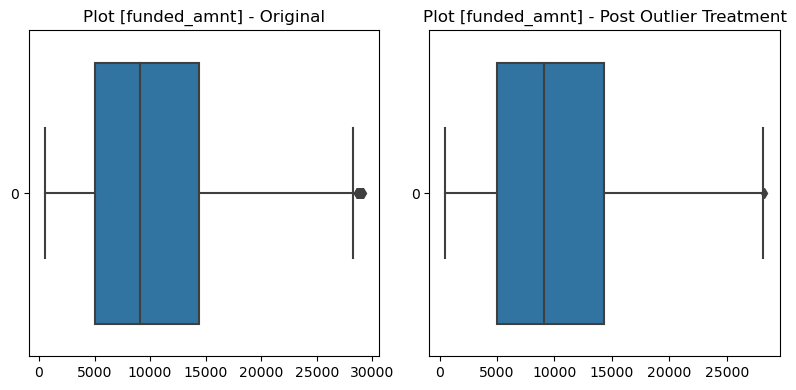

Rows dropped:  30
Percentage rows dropped:  0.08 %


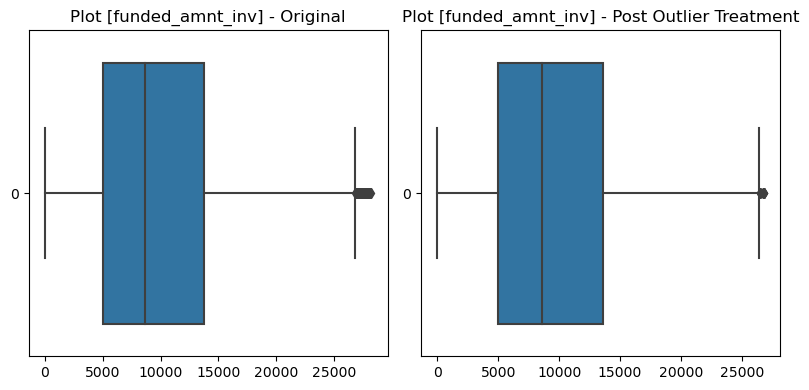

Rows dropped:  153
Percentage rows dropped:  0.43 %


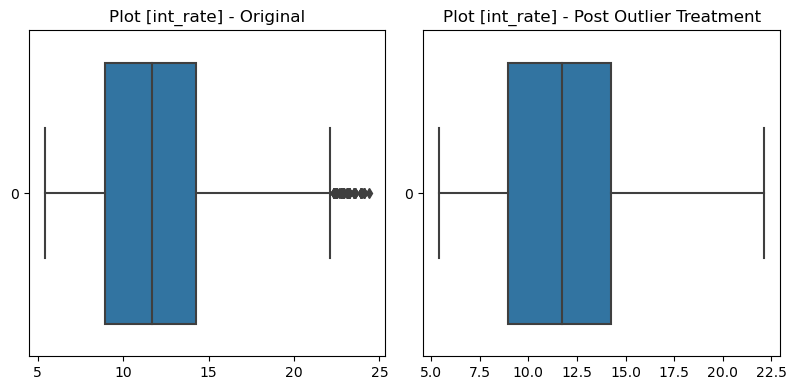

Rows dropped:  63
Percentage rows dropped:  0.18 %


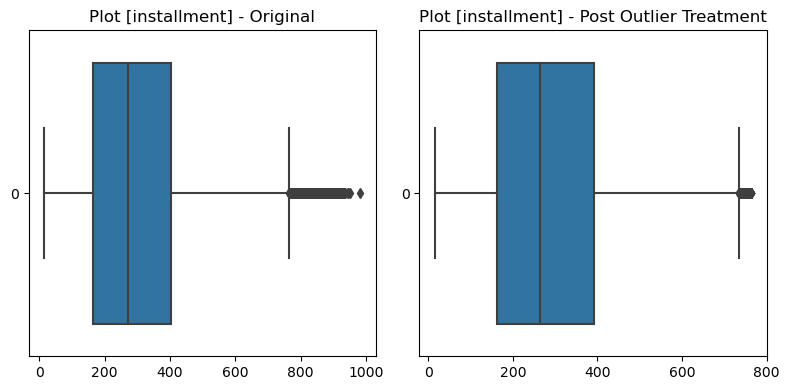

Rows dropped:  981
Percentage rows dropped:  2.76 %


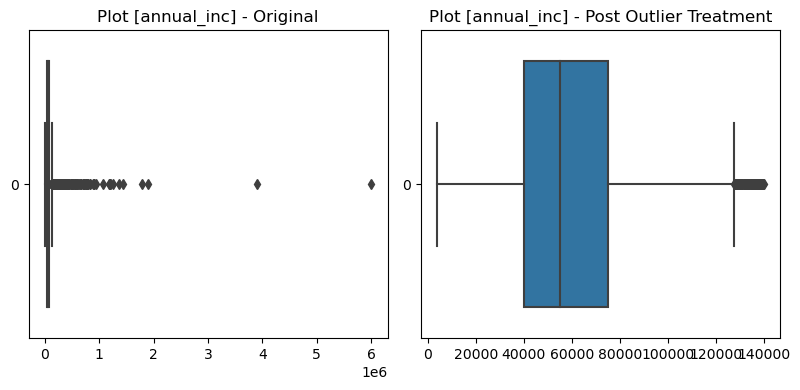

Rows dropped:  1486
Percentage rows dropped:  4.3 %


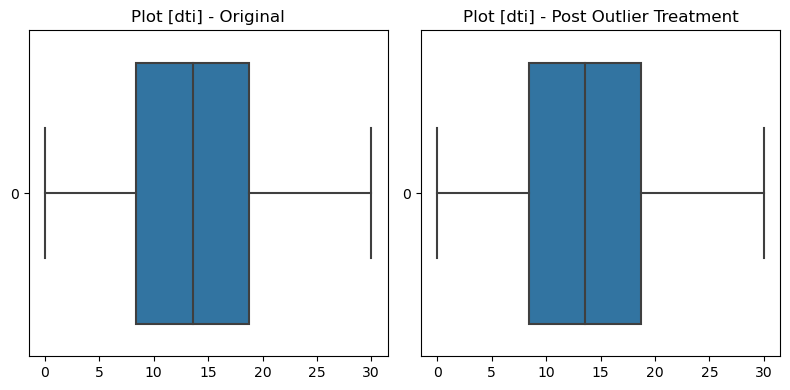

Rows dropped:  0
Percentage rows dropped:  0.0 %


33056

In [49]:
original_row_count = len(loandf)
print('original_row_count',original_row_count)

outlier_treatment = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti']
for column in outlier_treatment:
    visualize_outliers(loandf, column)
    loandf = remove_outliers(loandf, column)
len(loandf)

In [50]:
new_row_count = len(loandf)
print('Rows dropped: ', original_row_count - new_row_count)
print('Percentage rows dropped: ', round((original_row_count - new_row_count)/original_row_count*100,2), "%")

Rows dropped:  3791
Percentage rows dropped:  10.29 %


## Univeriate Analysis

In [51]:
# Column metadata used by functions below
column_titles = {
    'loan_amnt': 'Loan Amount',
    'funded_amnt': 'Funded Amount',
    'funded_amnt_inv': 'Funded Amount Investors',
    'term': 'Loan Term',
    'int_rate': 'Interest Rate',
    'installment': 'Installment',
    'grade': 'Grade',
    'emp_length': 'Employment Length',
    'home_ownership': 'Home Owner Status',
    'annual_inc': 'Annual Income', 
    'verification_status': 'Verification Status',
    'issue_d': 'Issue Date',
    'loan_status': 'Loan Status',
    'purpose': 'Purpose of Loan',
    'addr_state': 'State',
    'dti': 'Debt To Income Ratio',
    'pub_rec_bankruptcies': 'Bankruptcies Record',
    'issue_y': 'Issue Year',
    'issue_m': 'Issue Month',
    'issue_q': 'Issue Quarter',
    'loan_amnt_b': 'Loan Amount Bins',
    'funded_amnt_inv_b': 'Investor Funded Bins',
    'funded_amnt_b': 'Funded Amount Bins',
    'annual_inc_b': 'Annual Income Bins',
    'int_rate_b': 'Interest Rate Bins',
    'dti_b': 'DTI Bins'
}

In [52]:
def univariate_analysis(df, column):
    fig, p = plot.subplots(1,2, figsize=(16, 4))
    sea.distplot(df.loc[df[column].notnull(), column], kde=True, hist=True, ax=p[0])
    sea.boxplot(x=column, data=df, ax=p[1])
    p[0].set_xlabel(column_titles[column])
    p[1].set_xlabel(column_titles[column])
    plot.tight_layout()
    plot.show()

## Quantitative Variable Analysis

In [53]:
def univariate_analysis_1(df, columns):
    num_columns = len(columns)
    fig, p = plot.subplots(num_columns, 2, figsize=(16, 4*num_columns))
    for i, column in enumerate(columns):
        sea.distplot(df.loc[df[column].notnull(), column], kde=True, hist=True, ax=p[i, 0])
        sea.boxplot(x=column, data=df, ax=p[i, 1])
        p[i, 0].set_xlabel(column_titles[column])
        p[i, 1].set_xlabel(column_titles[column])
        p[i, 0].set_yticks([])
        p[i, 1].set_yticks([])
        p[i, 1].set_xticklabels(p[i, 1].get_xticklabels())
        mode_value = df[column].mode().values[0]
        p[i, 1].axvline(x=mode_value, color='red', linestyle='--', label='Mode')
        min_value = df[column].min()
        max_value = df[column].max()
        # Find the range where most of the values are present
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        p[i, 0].annotate(f'Most values between {q1} and {q3}', xy=(0, 1.1), xycoords='axes fraction', ha='left', va='bottom')
        p[i, 0].annotate(f'Range: {min_value} - {max_value}', xy=(0, 1.0), xycoords='axes fraction', ha='left', va='bottom')
        p[i, 0].annotate(f' ', xy=(0, 0.9), xycoords='axes fraction', ha='left', va='bottom')  # Add a newline
        p[i, 0].annotate(f'{i+1}.Univariate analysis of {column_titles[column]}', xy=(0.5, 1.2), xycoords='axes fraction', ha='center', va='bottom', fontsize=12, fontweight='bold')
        print()
    plot.tight_layout()
    plot.show()

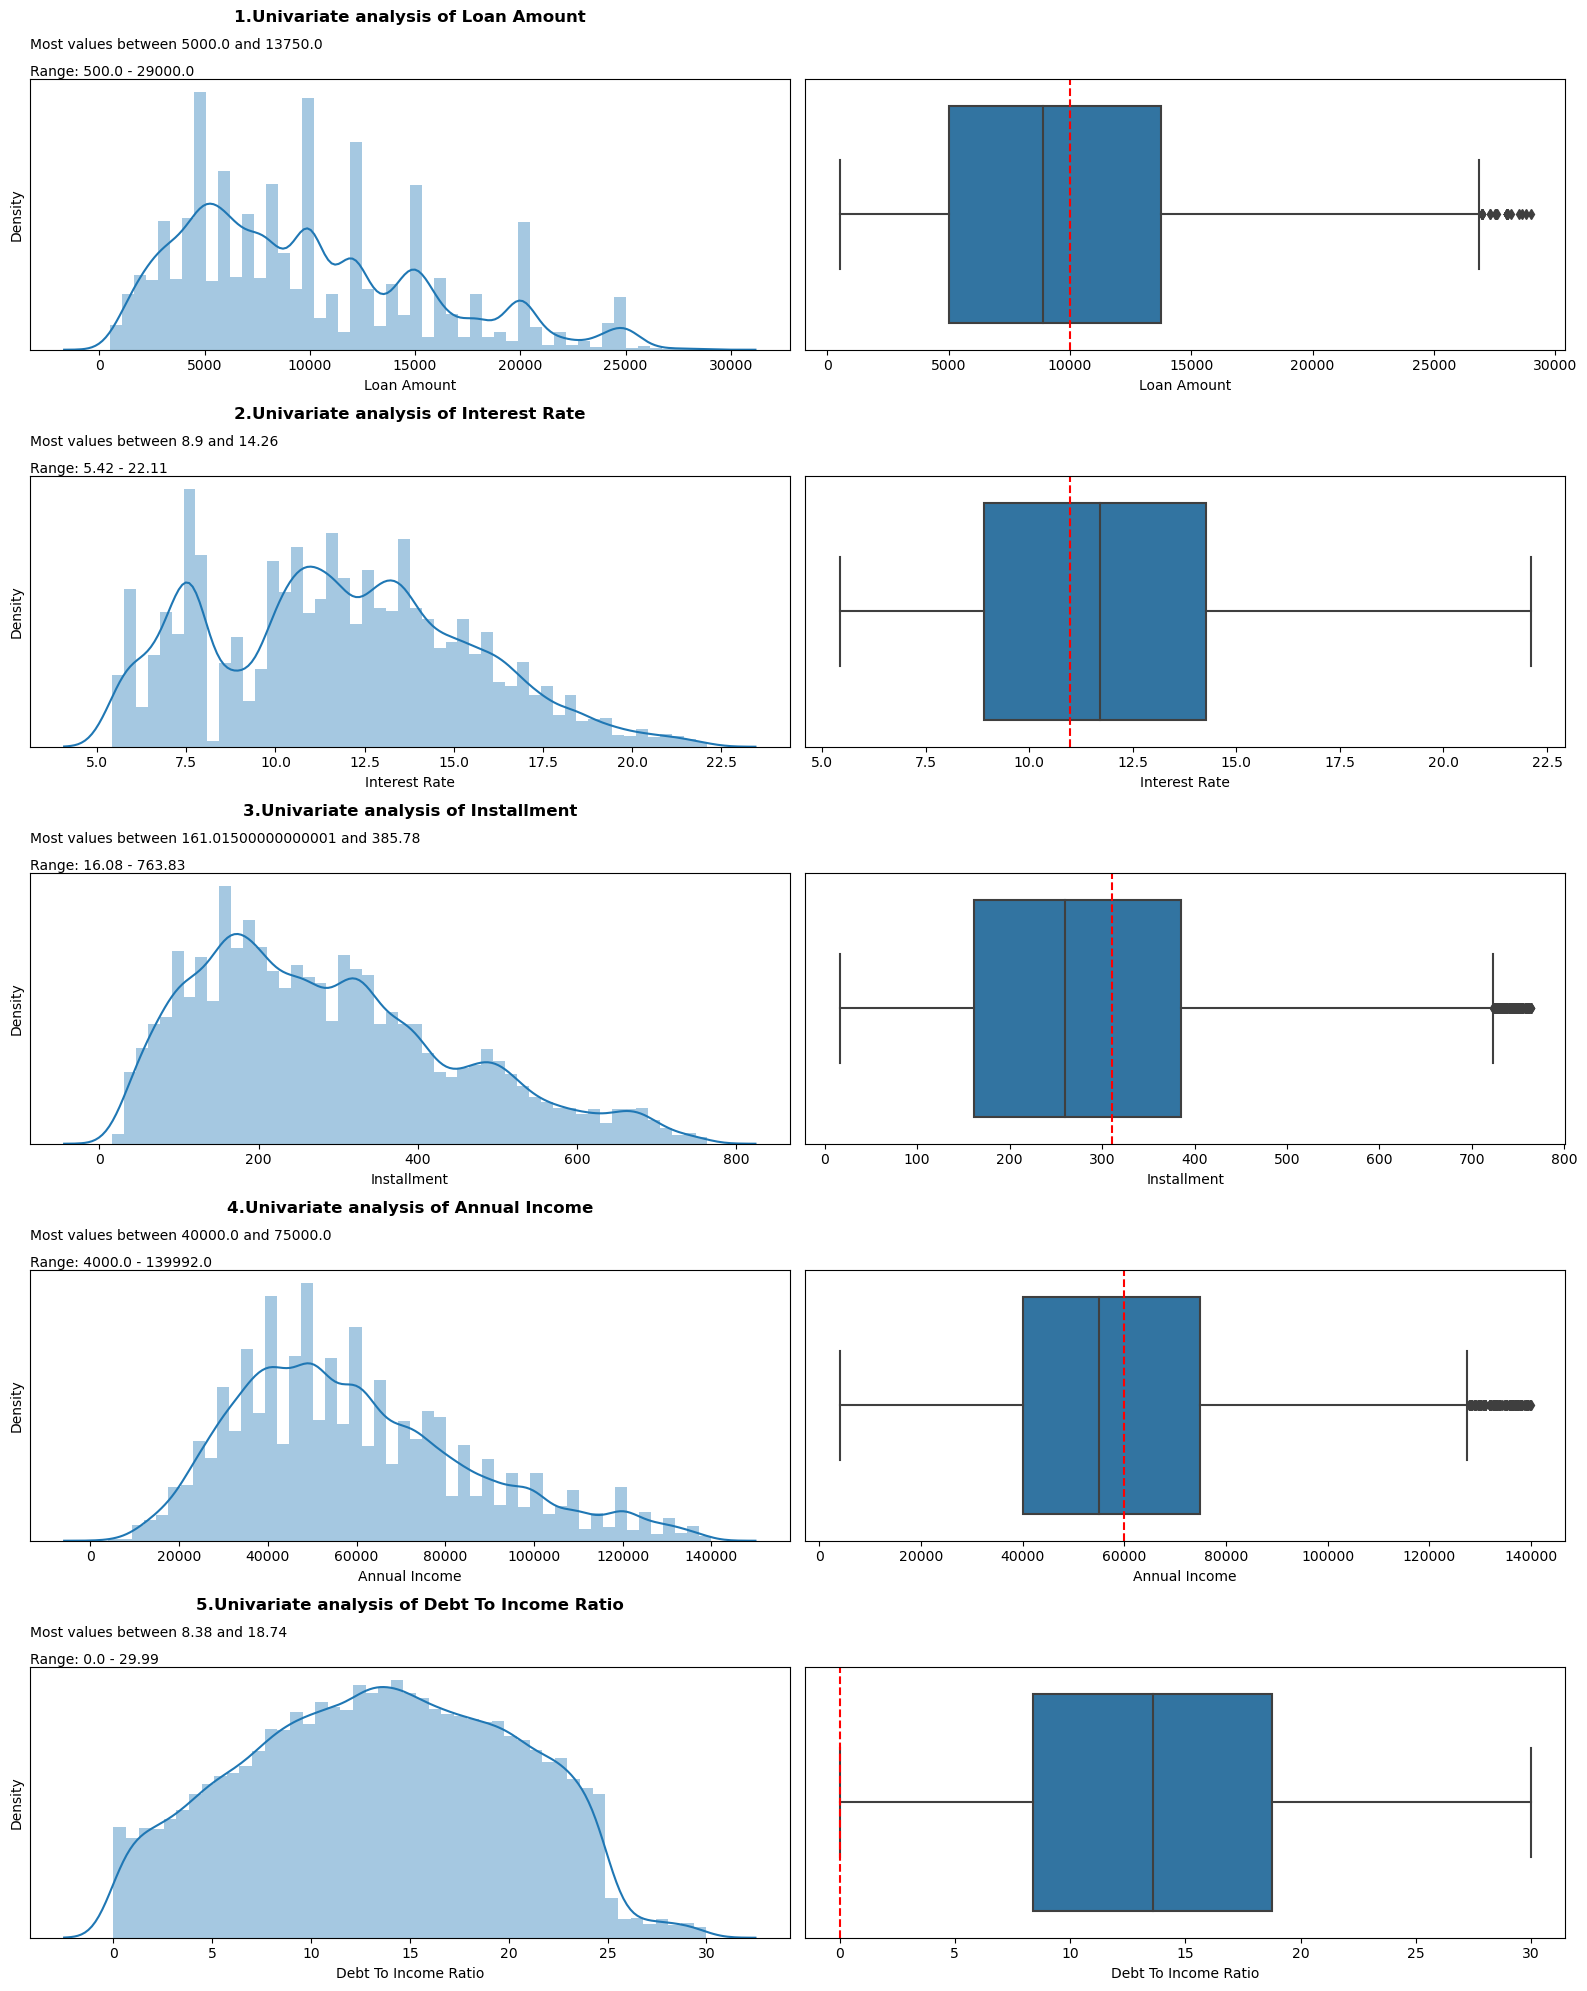

In [54]:
univariate_analysis_1(loandf,['loan_amnt','int_rate','installment','annual_inc','dti'])

### loan_amnt

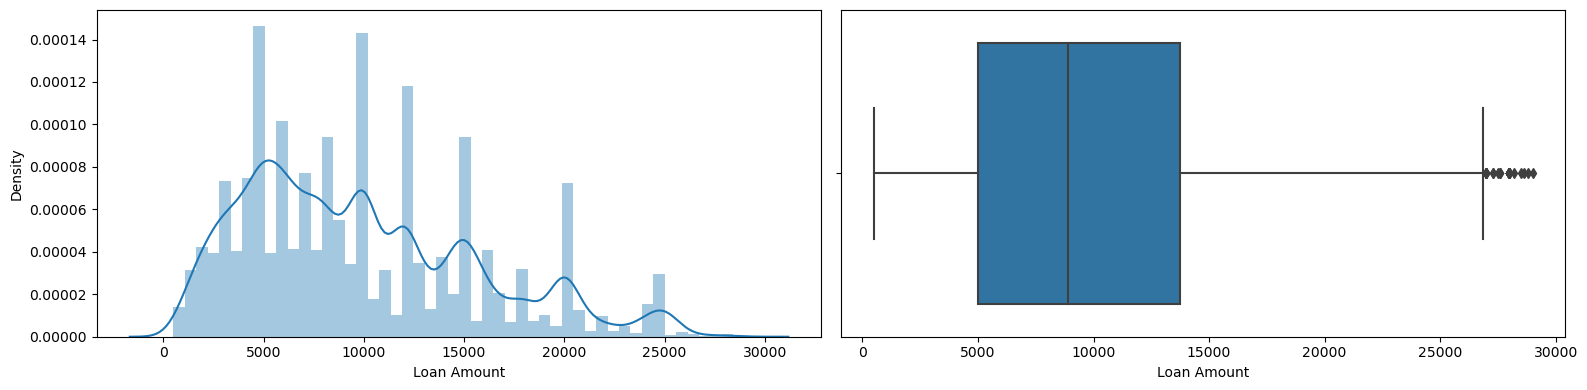

In [55]:
univariate_analysis(loandf, 'loan_amnt')

**Majority of the loan_amount is in the range of 5K to 14K**

### int_rate

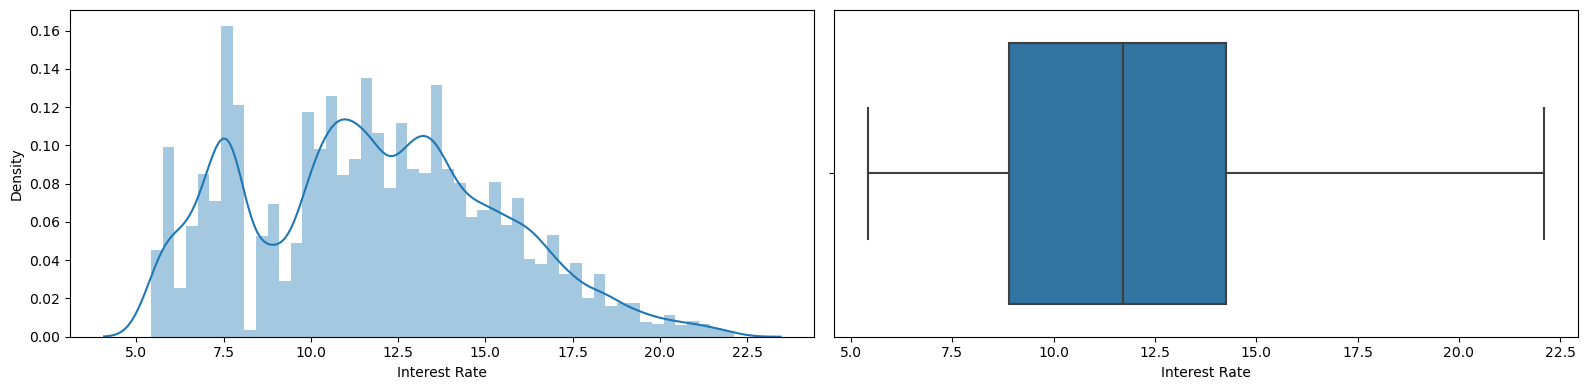

In [56]:
univariate_analysis(loandf, 'int_rate')

**Majority of the interest rate is in the range of 5% to 14% going at the max to 22%**
***

### installment

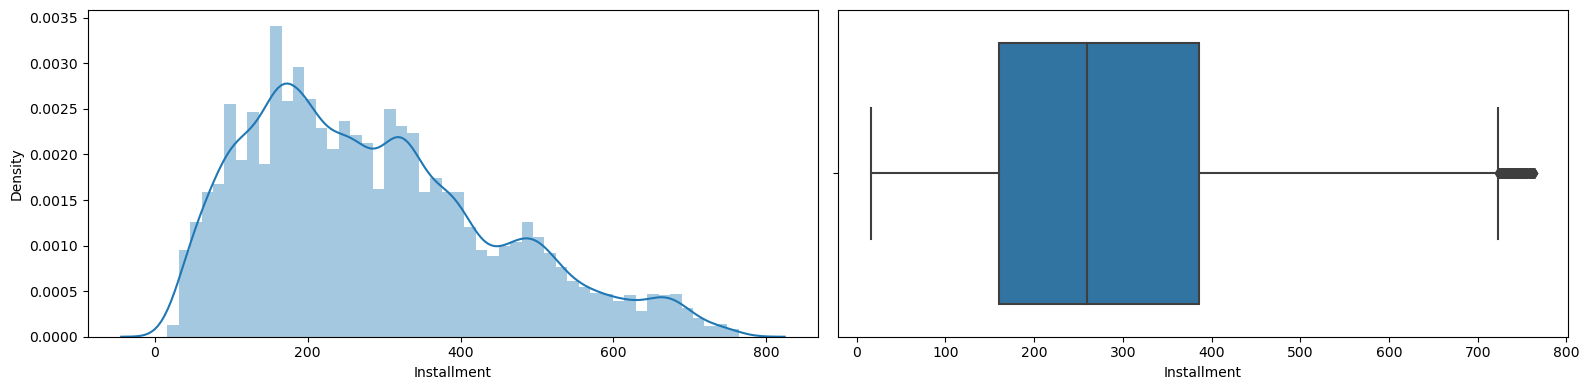

In [57]:
univariate_analysis(loandf, 'installment')

**Majority of the installment is in the range of 20 to 400 going at the max to 700**
***

### annual_inc

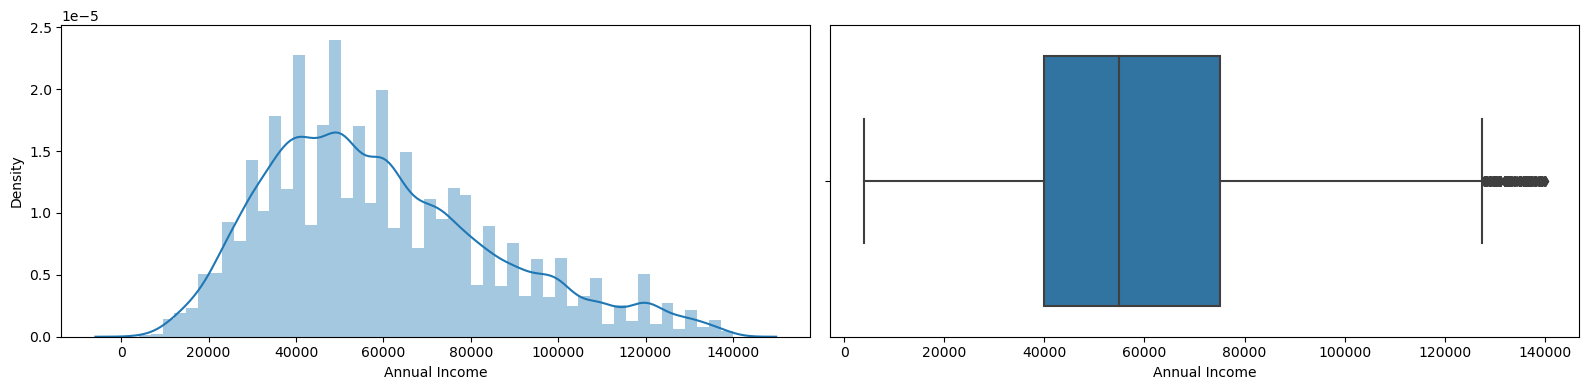

In [58]:
univariate_analysis(loandf, 'annual_inc')

**Majority of the annual income is in the range of 4k to 40k going at the max to 120k**. This column required major outlier treatment.
***

### dti

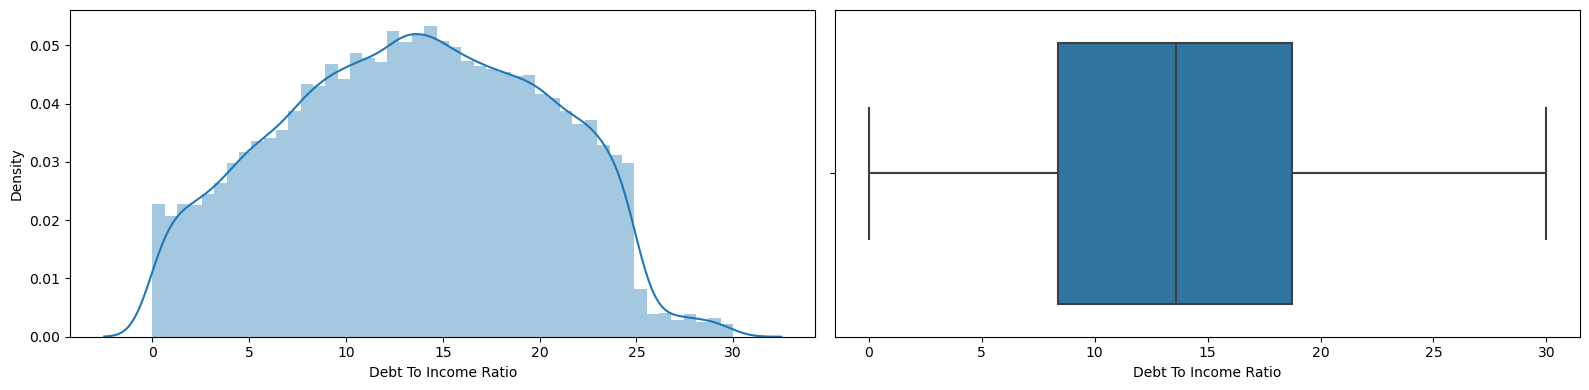

In [59]:
univariate_analysis(loandf, 'dti')

**Majority of the debt to income is in the range of 0 to 20 going at the max to 30**
***

## Unordered Categorical Variable Analysis

<Axes: title={'center': 'Home Ownership Distribution'}, xlabel='Home Ownership Category', ylabel='Frequency'>

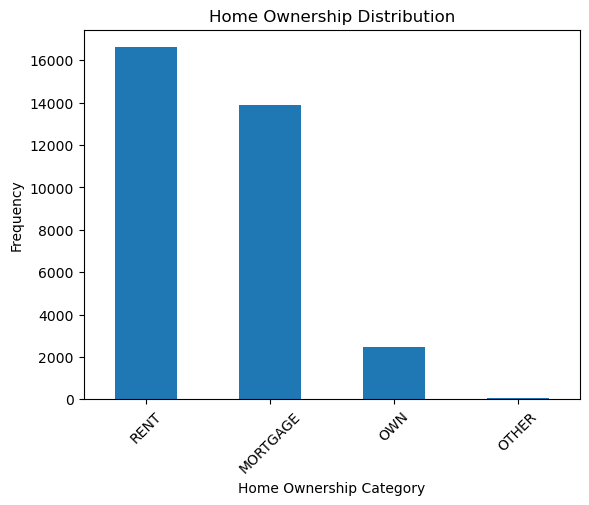

In [60]:
#loandf['home_ownership'].value_counts().plot.bar()
loandf['home_ownership'].value_counts().plot.bar(title='Home Ownership Distribution', xlabel='Home Ownership Category', ylabel='Frequency', rot=45)

**Majority of the home owner status are in status of RENT and MORTGAGE**

### purpose

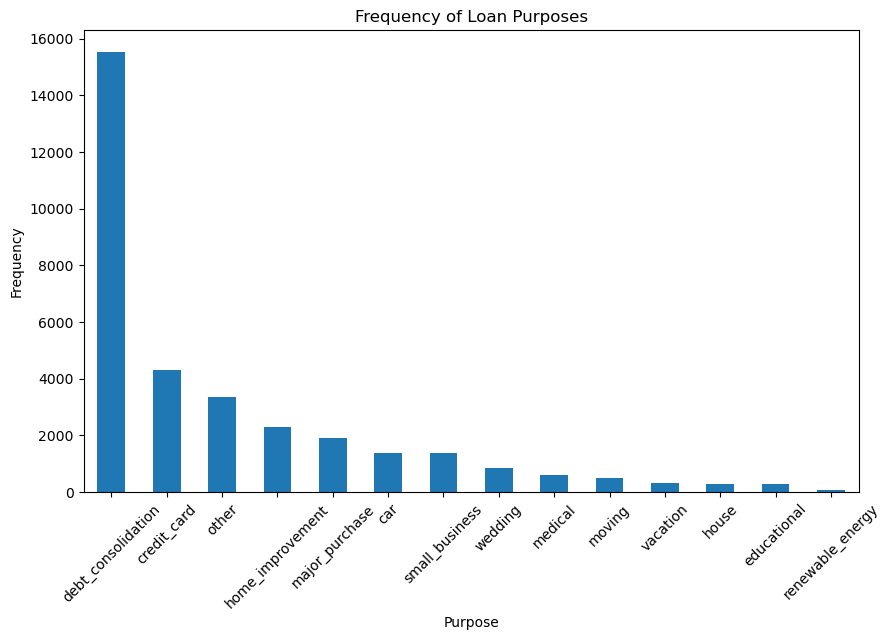

In [61]:
#loandf['purpose'].value_counts().plot.bar()
loandf['purpose'].value_counts().plot.bar(title='Frequency of Loan Purposes', xlabel='Purpose', ylabel='Frequency', rot=45, figsize=(10, 6));

**Majority of loan application are in the category of debt_consolidation**

### addr_state

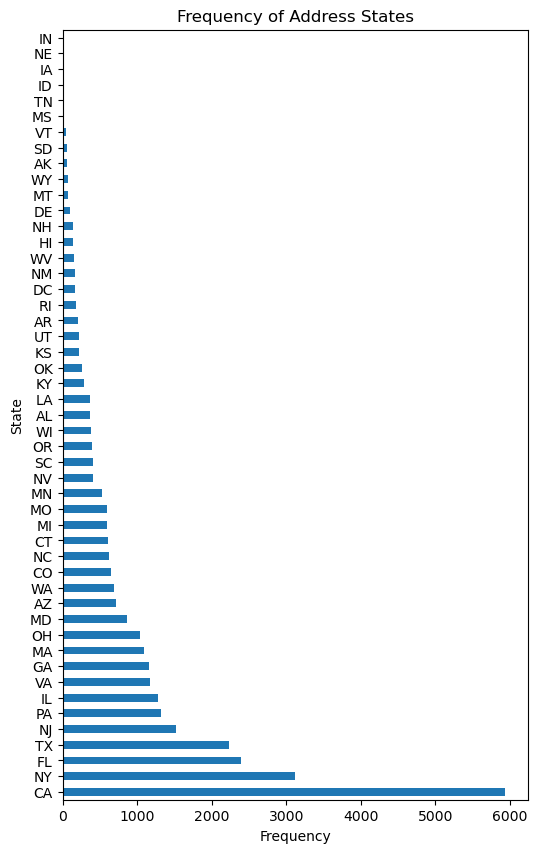

In [62]:
#loandf['addr_state'].value_counts().plot.bar()
loandf['addr_state'].value_counts().plot.barh(title='Frequency of Address States', xlabel='Frequency', ylabel='State', figsize=(6, 10));

**CA state has the maximum amount of loan applications**

## Ordered Categorical Variable Analysis

### term

<Axes: title={'center': 'Frequency of Loan Terms'}, xlabel='Term', ylabel='Frequency'>

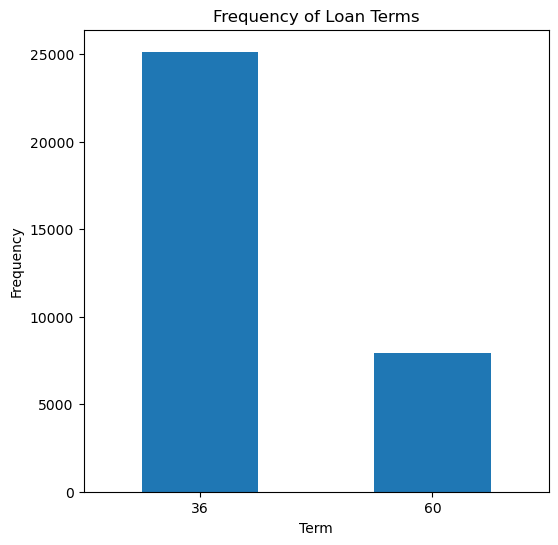

In [63]:
#loandf['term'].value_counts().plot.bar()
loandf['term'].value_counts().plot.bar(title='Frequency of Loan Terms', xlabel='Term', ylabel='Frequency', rot=0, figsize=(6, 6))

**Majority of the loan applications counts are in the term of 36 months.**

### grade

<Axes: title={'center': 'Frequency of Loan Grades'}, xlabel='Grade', ylabel='Frequency'>

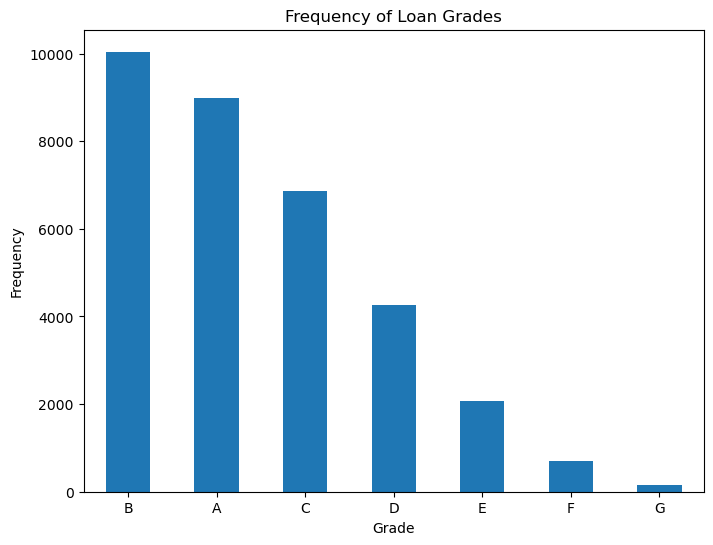

In [64]:
#loandf['grade'].value_counts().plot.bar()
loandf['grade'].value_counts().plot.bar(title='Frequency of Loan Grades', xlabel='Grade', ylabel='Frequency', rot=0, figsize=(8, 6))

Majority of loan application counts fall under the catogory of **Grade B**

### emp_length

<Axes: title={'center': 'Frequency of Employment Lengths'}, xlabel='Employment Length', ylabel='Frequency'>

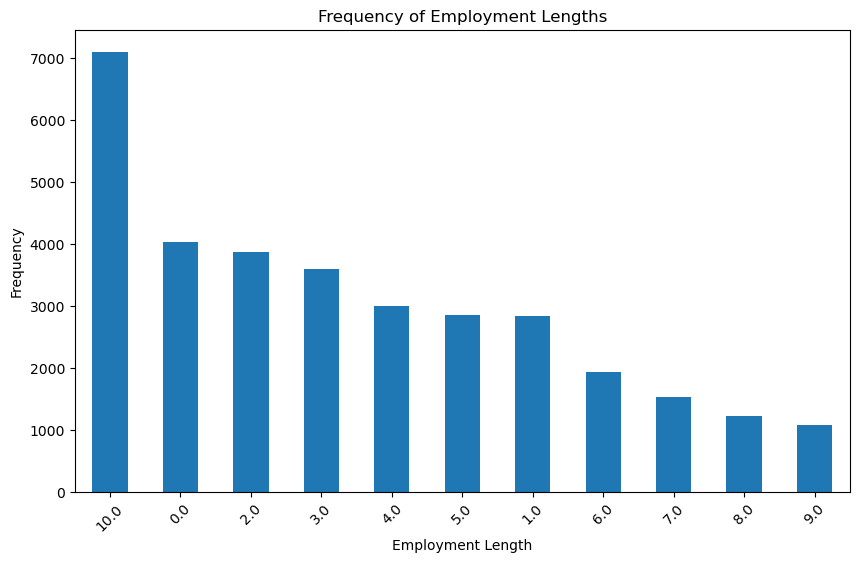

In [65]:
#loandf['emp_length'].value_counts().plot.bar()
loandf['emp_length'].value_counts().plot.bar(title='Frequency of Employment Lengths', xlabel='Employment Length', ylabel='Frequency', rot=45, figsize=(10, 6))

**Majority of the employment length of the customers are 10+ years and then in the range of 0-2 years**

### pub_rec_bankruptcies

<Axes: title={'center': 'Frequency of Public Record Bankruptcies'}, xlabel='Number of Bankruptcies', ylabel='Frequency'>

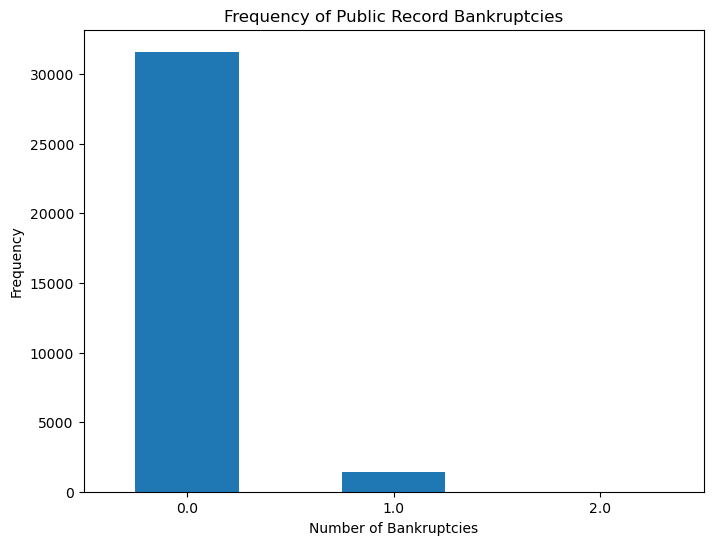

In [66]:
#loandf['pub_rec_bankruptcies'].value_counts().plot.bar()
loandf['pub_rec_bankruptcies'].value_counts().plot.bar(title='Frequency of Public Record Bankruptcies', xlabel='Number of Bankruptcies', ylabel='Frequency', rot=0, figsize=(8, 6))

Majority of the loan applicants are in the category of not having an public record of bankruptcies

## Derived Variable Analysis

### issue_y

<Axes: title={'center': 'Frequency of Loan Issue Years'}, xlabel='Year', ylabel='Frequency'>

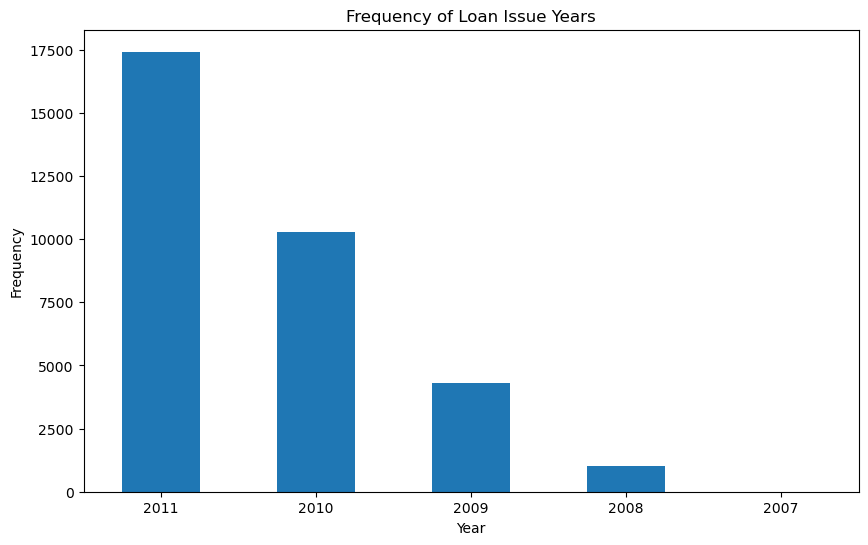

In [67]:
#loandf['issue_y'].value_counts().plot.bar()
loandf['issue_y'].value_counts().plot.bar(title='Frequency of Loan Issue Years', xlabel='Year', ylabel='Frequency', rot=0, figsize=(10, 6))

Loan application counts are increasing year over year.

### issue_m

<Axes: title={'center': 'Frequency of Loan Issue Months'}, xlabel='Month', ylabel='Frequency'>

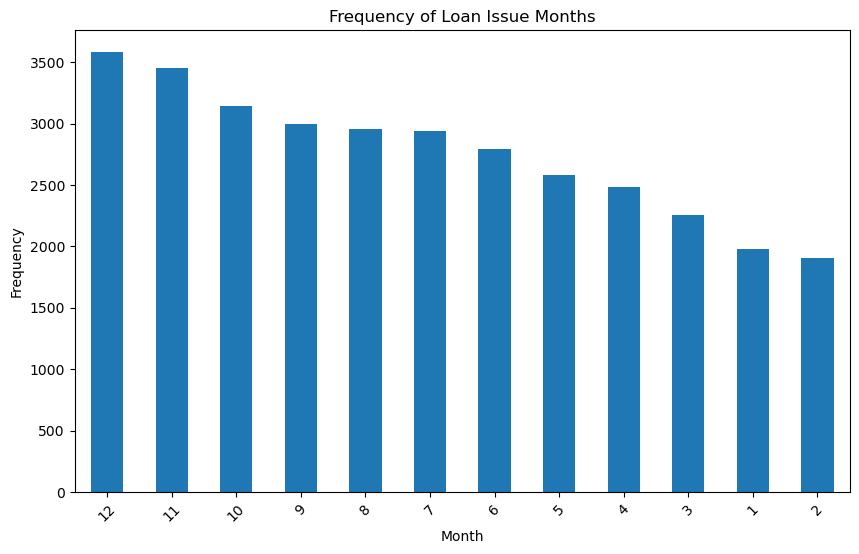

In [68]:
loandf['issue_m'].value_counts().plot.bar(title='Frequency of Loan Issue Months', xlabel='Month', ylabel='Frequency', rot=45, figsize=(10, 6))

The lowest loans applocation count are in the month of Jan/Feb/March and highest counts are in Oct/Nov/Dec. 
 - Possibly because by year ends people face the financial challenges
 - Possibly because of festive seasons
 - Possibly because they are consolidating debt by year end

### issue_q

<Axes: title={'center': 'Frequency of Loan Issue Quarters'}, xlabel='Quarter', ylabel='Frequency'>

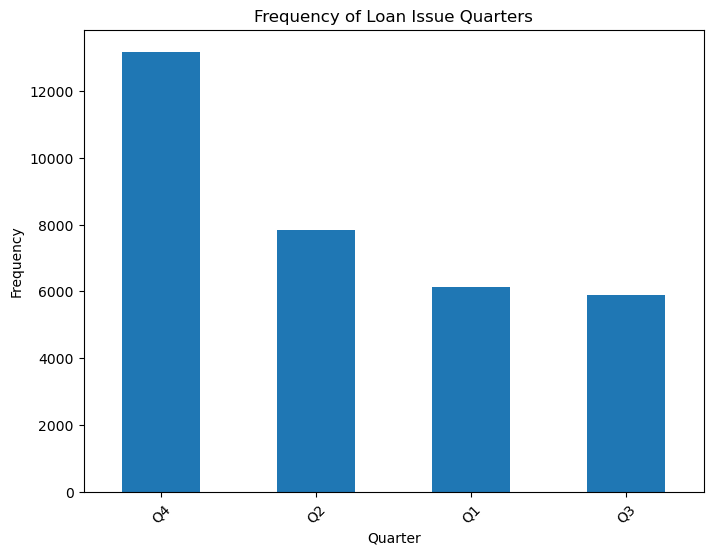

In [69]:
#loandf['issue_q'].value_counts().plot.bar()
loandf['issue_q'].value_counts().plot.bar(title='Frequency of Loan Issue Quarters', xlabel='Quarter', ylabel='Frequency', rot=45, figsize=(8, 6))

Highest loan application volume in Quarter 4 of a year

### loan_amnt_b

<Axes: title={'center': 'Frequency of Loan Amounts (in thousand)'}, xlabel='Loan Amount (in thousand)', ylabel='Frequency'>

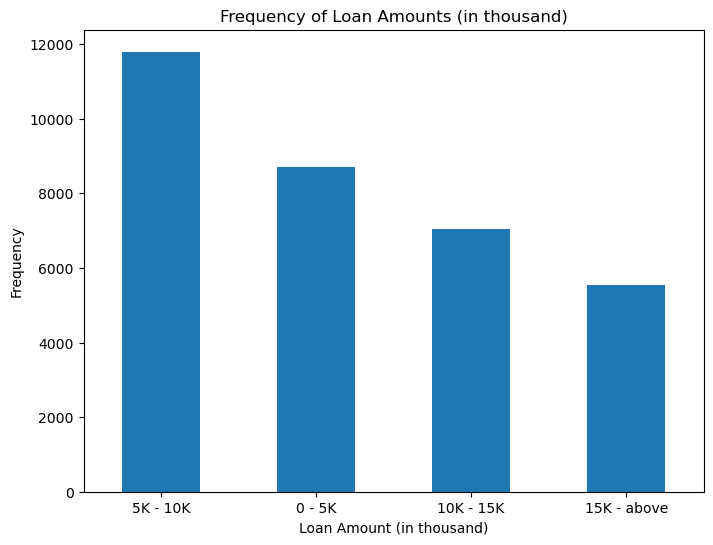

In [70]:
#loandf['loan_amnt_b'].value_counts().plot.bar()
loandf['loan_amnt_b'].value_counts().plot.bar(title='Frequency of Loan Amounts (in thousand)', xlabel='Loan Amount (in thousand)', ylabel='Frequency', rot=0, figsize=(8, 6))

Highest loan amount applications fall in the range of 5k to 10k

### annual_inc_b

<Axes: title={'center': 'Frequency of Annual Incomes (in thousands)'}, xlabel='Annual Income (in thousands)', ylabel='Frequency'>

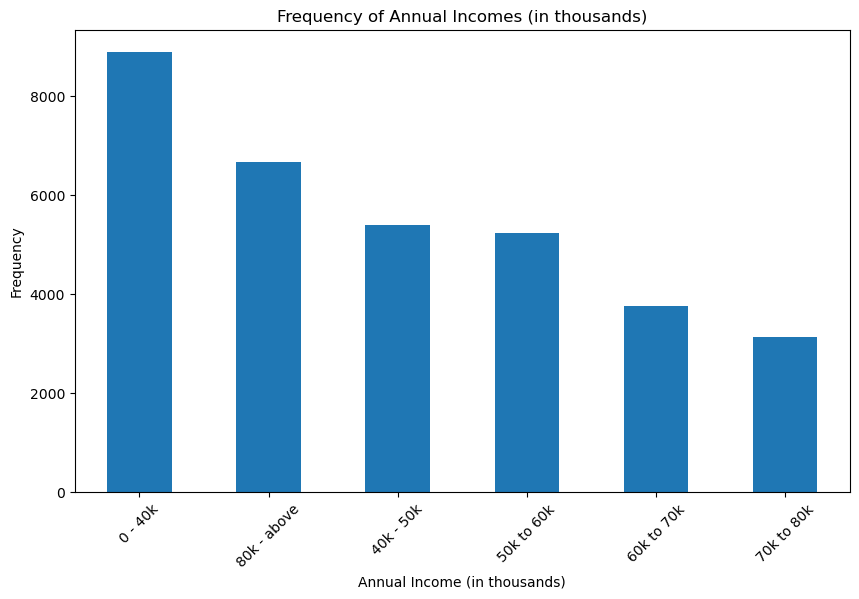

In [71]:
#loandf['annual_inc_b'].value_counts().plot.bar()
loandf['annual_inc_b'].value_counts().plot.bar(title='Frequency of Annual Incomes (in thousands)', xlabel='Annual Income (in thousands)', ylabel='Frequency', rot=45, figsize=(10, 6))

Majority of the loan applicants are in the range of 0 - 40K anual income

### int_rate_b

<Axes: title={'center': 'Frequency of Interest Rates'}, xlabel='Interest Rate', ylabel='Frequency'>

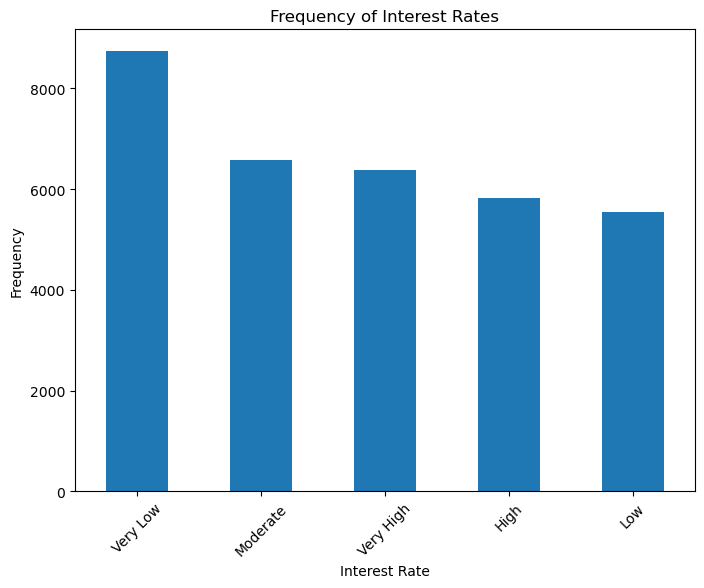

In [72]:
#loandf['int_rate_b'].value_counts().plot.bar()
loandf['int_rate_b'].value_counts().plot.bar(title='Frequency of Interest Rates', xlabel='Interest Rate', ylabel='Frequency', rot=45, figsize=(8, 6))

Majority of the loan applications are in the category of Very Low interest rates

### dti_b

<Axes: title={'center': 'Frequency of Debt-to-Income (DTI) Categories'}, xlabel='DTI Category', ylabel='Frequency'>

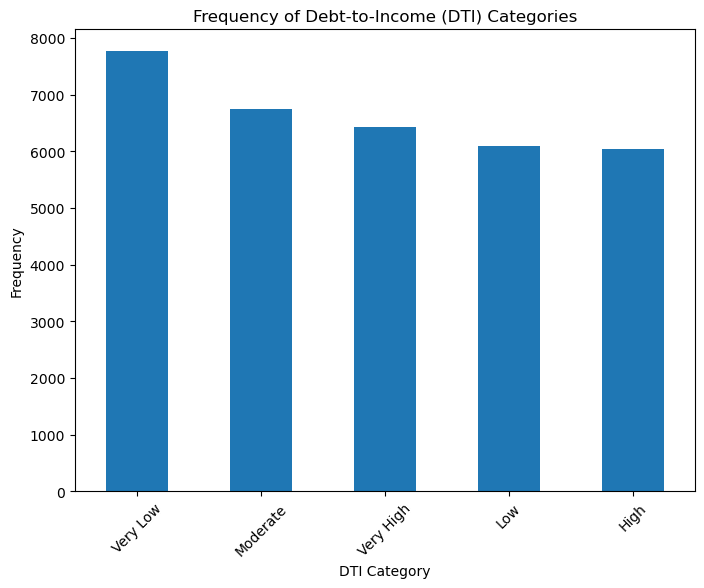

In [73]:
#loandf['dti_b'].value_counts().plot.bar()
loandf['dti_b'].value_counts().plot.bar(title='Frequency of Debt-to-Income (DTI) Categories', xlabel='DTI Category', ylabel='Frequency', rot=45, figsize=(8, 6))

Majority of the loan applications are in Moderate debt to income ratio

## Univariate Analysis Summary

### Customer Demographics
- Majority of the loan applicants are in the range of 0 - 40K annual income
- Majority of the debt to income is in the range of 0 to 20 going at the max to 30
- Majority of the home owner status are in status of RENT and MORTGAGE
- Highest loan applications are in the category of debt_consolidation
- CA state has the maximum amount of loan applications
- Majority of the loan applicants are in the category of not having an public record of bankruptcies
- Majority of the employment length of the customers are 10+ years and then in the range of 0-2 years

### Loan Demographics
- Highest loan amount applications fall in the range of 5k to 10k
- Majority of the interest rate is in the range of 5% to 16% going at the max to 22%
- Majority of the installment amount is in the range of 20$ to 400$
- Majority of the loan applications counts are in the term of 36 months
- Majority of loan application counts fall under the catogory of Grade B

### Time Based Analysis
- Loan application counts are increasing year over year
- Highest loan application volume in Quarter 4 of every year
- Lowest loan applications are in Q1
     - Possibly because by year ends people face the financial challenges
     - Possibly because of festive seasons
     - Possibly because they are consolidating debt by year end

### Inferences
- The customer demographic data shows which segment of customers to target for highest volume of loan
- Indicates more analysis is needed why other categories are not as high as other few
- Indicates the LendingClub to be prepared with volume in Q4
- Indicates the LendingClub to target customers in other quarters to increase sales

## Bivariate Analysis

Identify causes and data which contribute to more Charge Off's

In [74]:
# Bivariate analysis of columns against loan_status and calculate the ratio of Charge Offs
def analysis_vs_loan_status(df, col):
    fig, p = plot.subplots(1,2, figsize=(16, 4))
    splot = sea.countplot(df[col], ax=p[0])
    splot.set_xticklabels(splot.get_xticklabels(), rotation=90);
    p[0].set_title('['+ col + '] - loan_status=all')
    cross_tab = pd.crosstab(df[col], df['loan_status'], normalize='index')
    cross_tab.plot.bar(ax=p[1], stacked=True)
    p[1].set_title('['+ col + '] - Stacked')
    plot.show()


def continious_column_analysis(df, column):
    f, (ax1, ax2) = plot.subplots(nrows=1, ncols=2, figsize=(16,4))
    sea.distplot(df.loc[df[column].notnull(), column], kde=True, hist=True, ax=ax1)
    sea.boxplot(x=column, y='loan_status', data=df, ax=ax2)
    ax1.set_xlabel(column_titles[column])
    ax2.set_xlabel(column_titles[column] + 'by Loan Status')
    plot.tight_layout()
    plot.show()
    # return group by dataframe for display comparison
    return df.groupby('loan_status')[column].describe()

def comparison_loan_status(df, column):
    df.groupby('loan_status')[column].value_counts().unstack().plot(kind='bar', figsize=[16,4])
    plot.show()


def ratio_wise(df, column):
    rw = df.pivot_table(index=column, columns='loan_status', values='id', aggfunc=len).reset_index()
    rw['total'] = rw['Charged Off'] + rw['Fully Paid']
    rw['charge_off_ratio'] = round(rw['Charged Off'] / rw['total'] * 100)
    rw.sort_values(by='total', ascending=False)
    return rw

def ratio_wise_plot(df, column, invert=False):
    plot.figure(figsize=[20,8])
    plot.title('Charged Off : ' + column_titles[column])
    rw = ratio_wise(df, column)
    if invert:
        sea.barplot(x=rw['charge_off_ratio'], y=rw[column])
    else:
        sea.barplot(x=rw[column], y=rw['charge_off_ratio'])       
    plot.tight_layout()
    plot.show()
    return rw

def series_plot(df, column, hue=None, annot=1):
        temp = pd.Series()
        fig, ax = plot.subplots(figsize=(20,14))
        width = len(df[column].unique()) + 6 + 4 * len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sea.countplot(data = df, x=column, order=df[column].value_counts().index, hue=hue) 
        if annot == 1:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))  
        elif annot == 2:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
        plot.show()
def series_plot_1(df, column, hue=None, annot=1, annot_format='{:.1f}%'):
    # Calculate plot width based on category count
    plot_width = len(df[column].unique()) * 1.5
    
    # Create figure and axis
    fig, ax = plot.subplots(figsize=(plot_width, 7))
    
    # Create count plot with optional hue mapping
    ax = sea.countplot(data=df, x=column, order=df[column].value_counts().index, hue=hue)
    
    # Annotate bars with percentages or counts
    if annot == 1:
        for p in ax.patches:
            ax.annotate(annot_format.format((p.get_height()*100)/float(len(df))), (p.get_x()+0.05, p.get_height()+20))
    elif annot == 2:
        for p in ax.patches:
            ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.32, p.get_height()+20))
    
    # Add title and labels
    ax.set_title('Count Plot of {}'.format(column))
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    
    # Show plot
    plot.show()

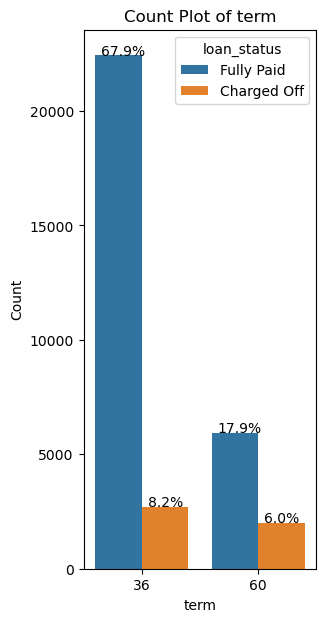

In [75]:
# Overall ratio of Charge Offs
series_plot_1(loandf, 'term', 'loan_status')

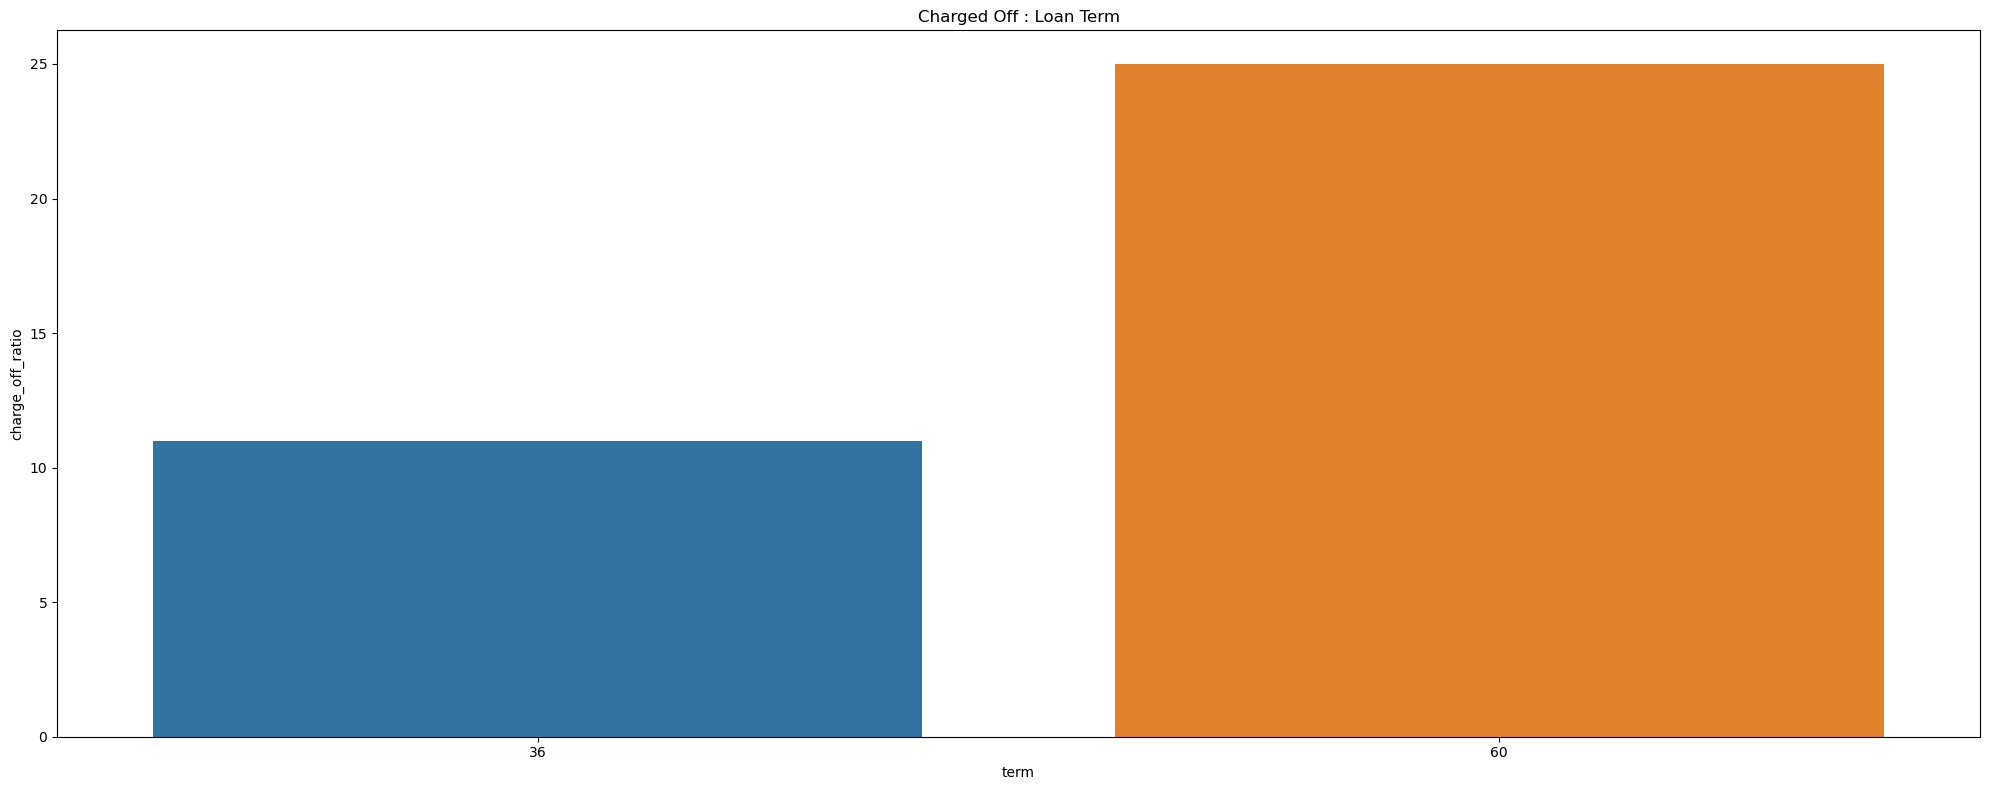

loan_status,term,Charged Off,Fully Paid,total,charge_off_ratio
0,36,2710,22429,25139,11.0
1,60,1990,5927,7917,25.0


In [76]:
## The ratio of Charge Offs within the category
ratio_wise_plot(loandf, 'term')

***
- The volume of loans are in the category of term = 36
- The overall percentage of Charge Off's is slightly higher in term = 36 (8%) as compared to term=60 (6%)
- If we calculate the ratio of Charge Off's within a category
    - **Charge Off**s ratio is for the term=60 is 25% which is much higher than term=36 (10%)
    - **term=60 is the loan applications which require more scrutiny**
- **Inferences**
    - Most of the applicants with term=60 potentially will have high Charge Offs
***

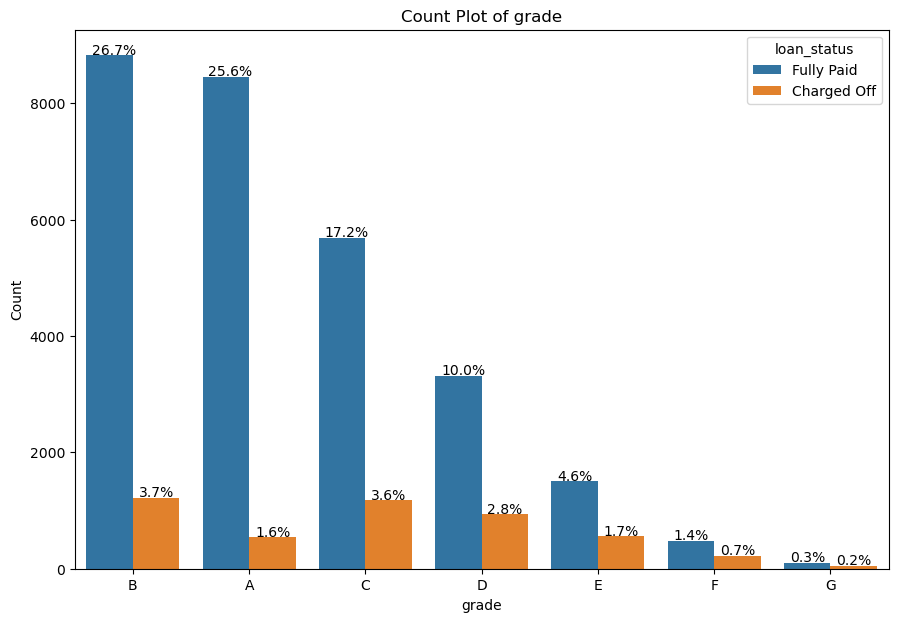

In [77]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'grade', 'loan_status')

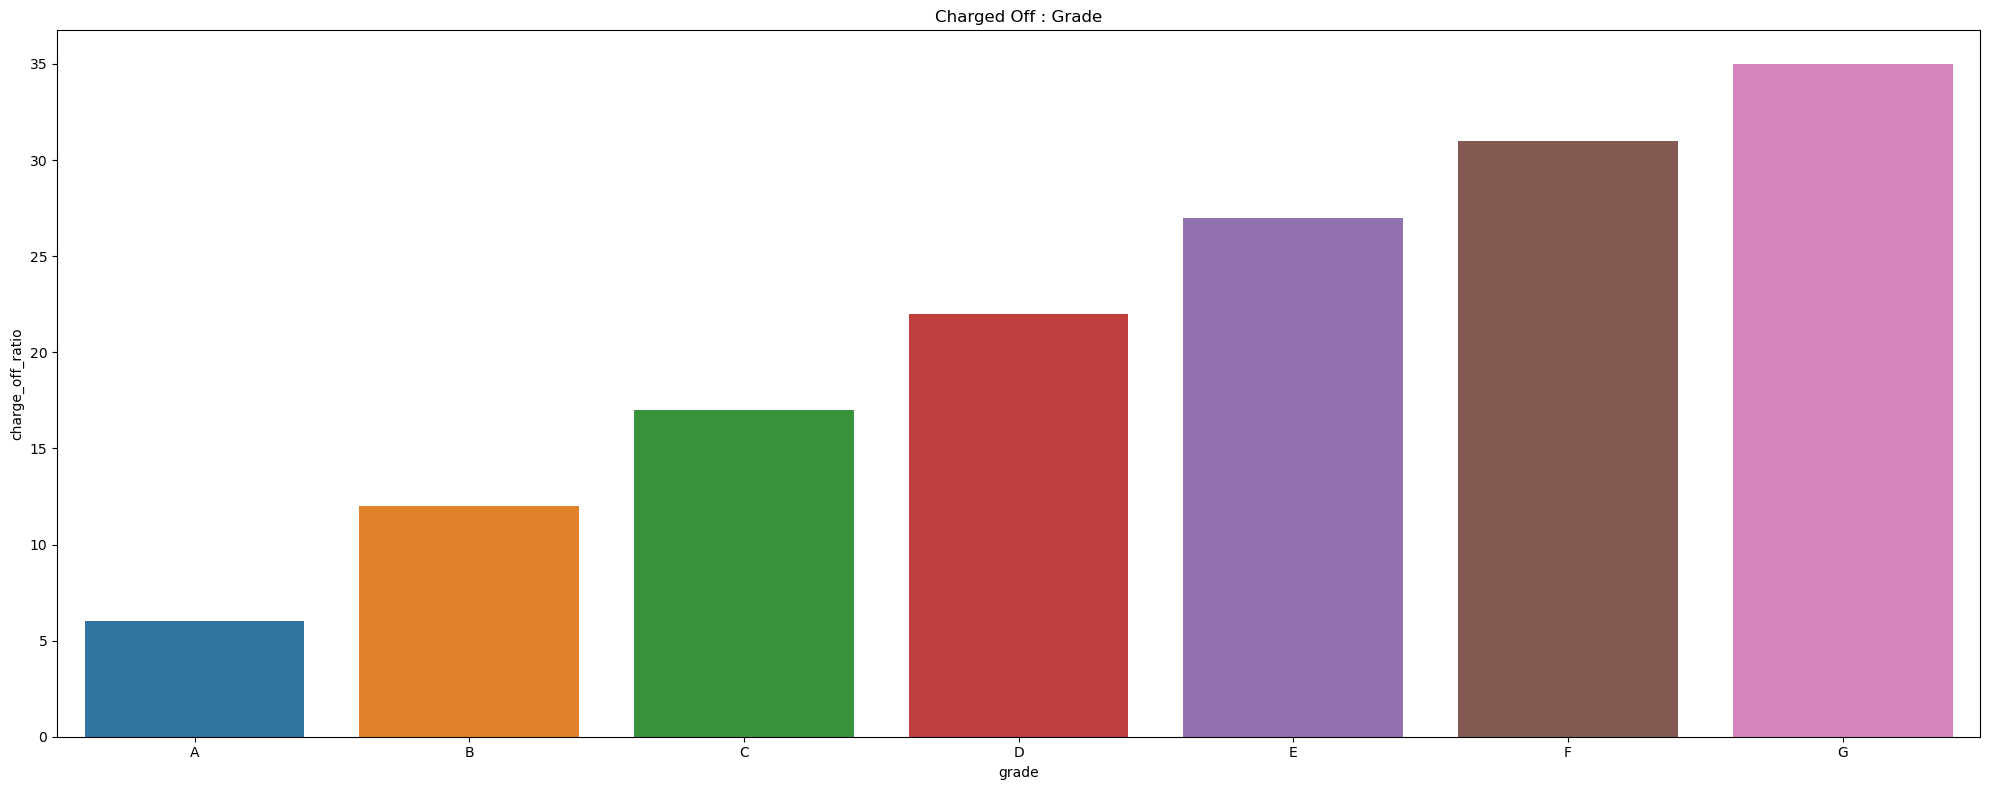

loan_status,grade,Charged Off,Fully Paid,total,charge_off_ratio
0,A,537,8451,8988,6.0
1,B,1222,8821,10043,12.0
2,C,1175,5683,6858,17.0
3,D,937,3316,4253,22.0
4,E,555,1505,2060,27.0
5,F,219,477,696,31.0
6,G,55,103,158,35.0


In [78]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'grade')

***
- The Majority of *loan volume is in grade=B*
- Highest percentage of overall Charge Offs are in grade B (3.7%) and C(3.6%)
- If we analyse the Charge Off Ratio within a category
    - The highest percentage of **Charge Off**s are in the *grade=G*
    - Highest cluster of **Charge Off**s are in the grades G,F (> 30%)
    - The volume of Grade G is extremely low 158 thus it does not contribute to overall risk significantly
- **Inferences**
    - Highest risk of charge off's are in the grades of B and C
    - Grade "F" and "G" have very high chances of charged off. The columes are low
    - Grade "A" has very less chances of charged off.
    - Probablity of charged off is increasing from "A" to "G"
***

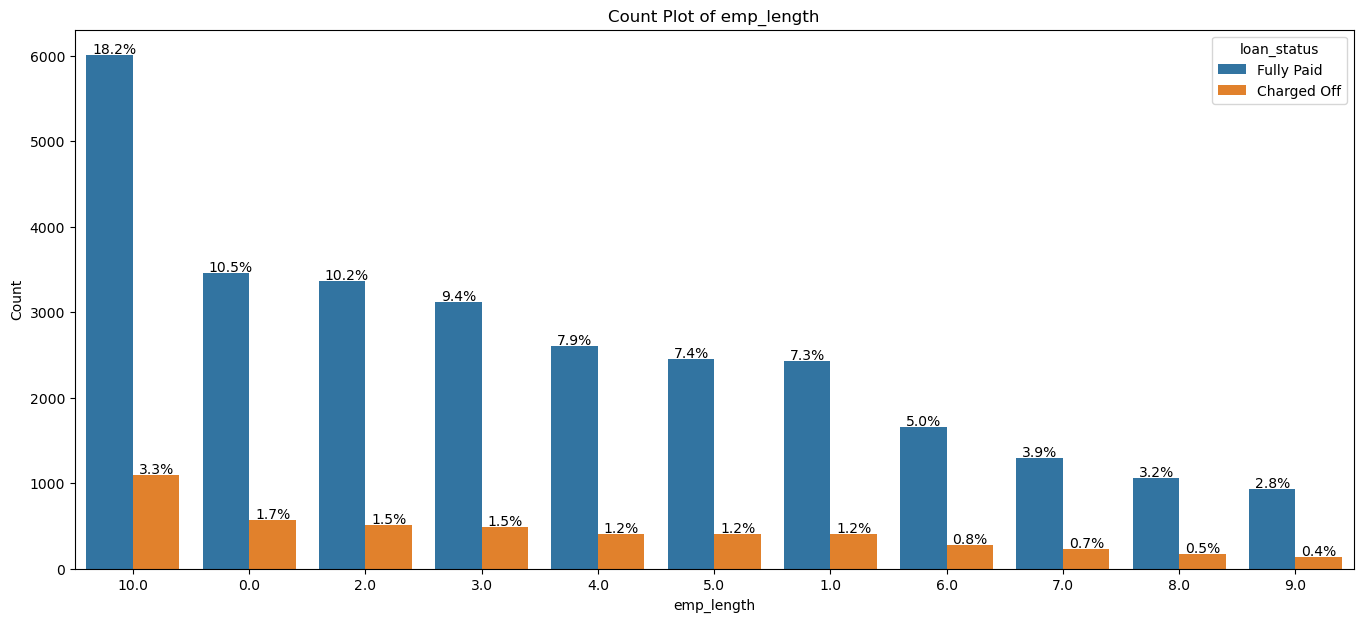

In [79]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'emp_length', 'loan_status')

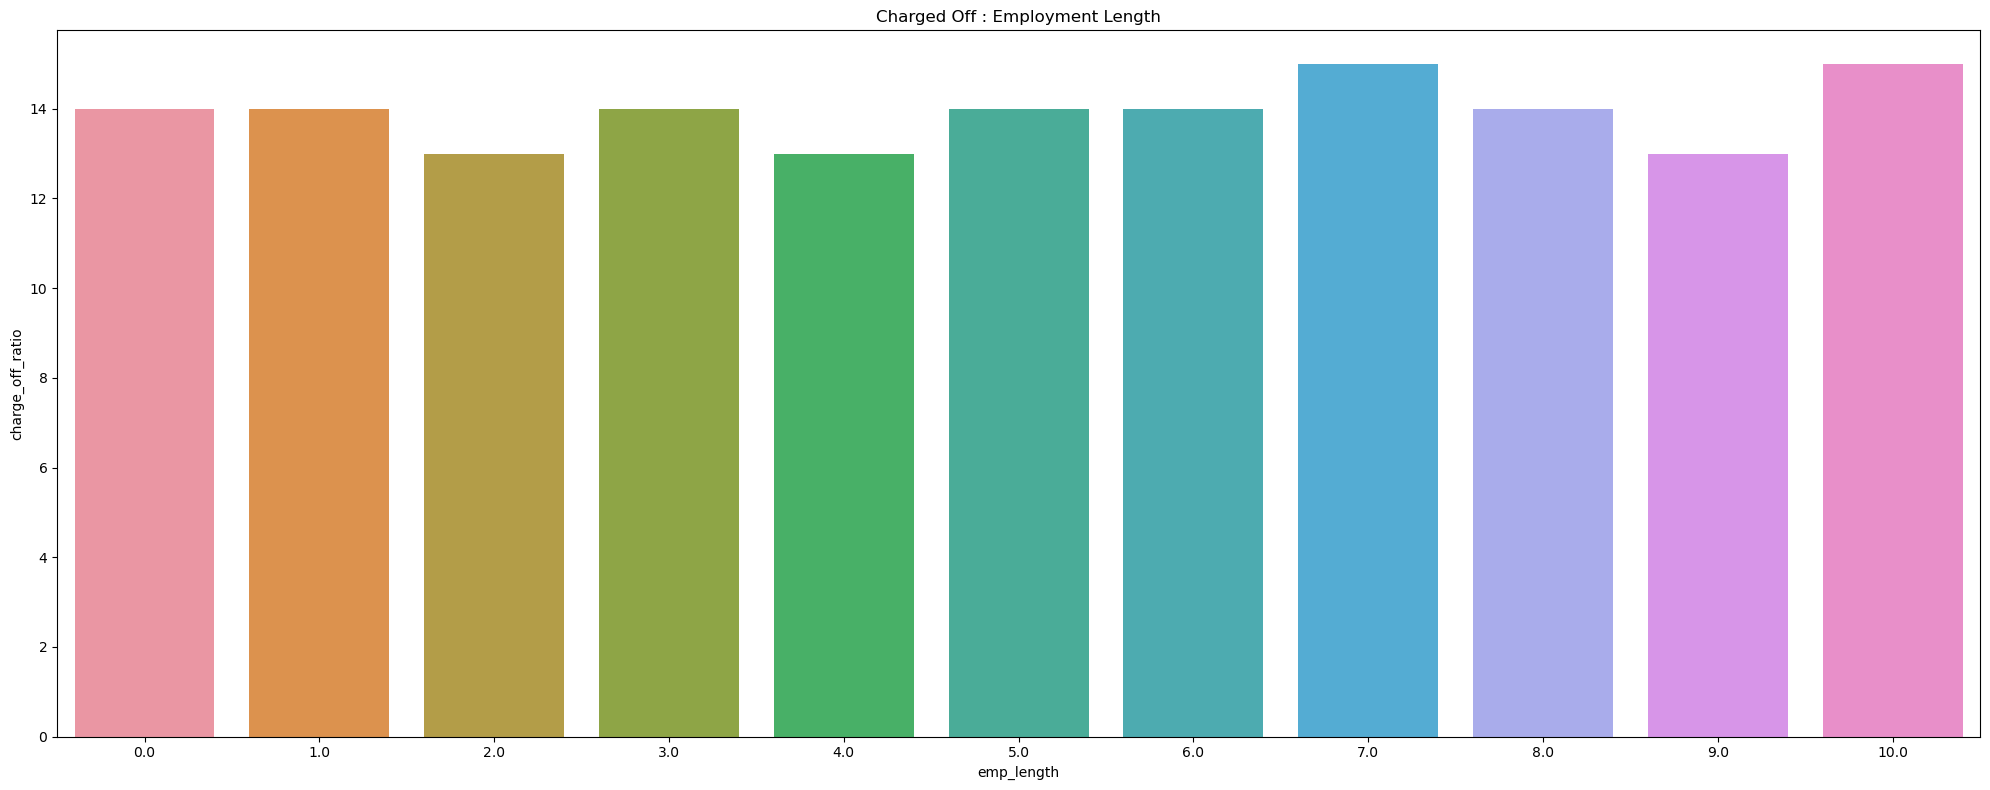

loan_status,emp_length,Charged Off,Fully Paid,total,charge_off_ratio
0,0.0,565,3461,4026,14.0
1,1.0,408,2427,2835,14.0
2,2.0,509,3360,3869,13.0
3,3.0,491,3113,3604,14.0
4,4.0,401,2598,2999,13.0
5,5.0,408,2449,2857,14.0
6,6.0,272,1659,1931,14.0
7,7.0,233,1294,1527,15.0
8,8.0,176,1056,1232,14.0
9,9.0,141,936,1077,13.0


In [80]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'emp_length')

***
- Highest Charge Offs are in the employee length categoty of 10 Years and above
- Charge Off ratio within the categories itself are similar and inconclusive
- **Inferences**
    - Highest Charge Offs are in the employee length of 10 Years and above
    - High probablity of Charge Off's whose income range is less than 1 years
    - Ratio within the ranges are pretty much same (in conclusive)
***

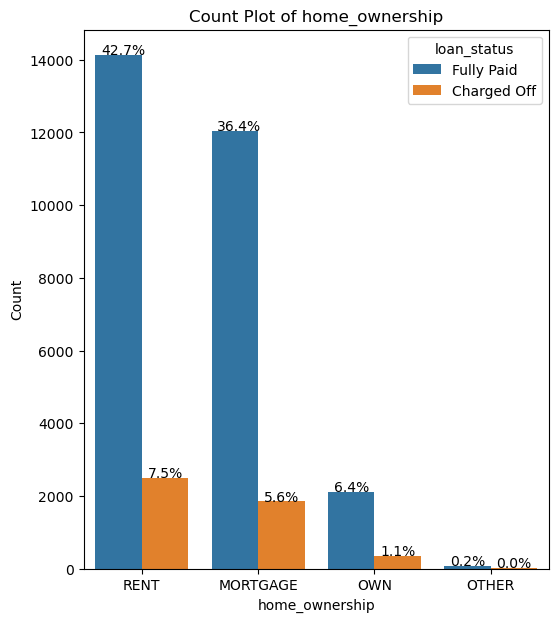

In [81]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'home_ownership', 'loan_status')

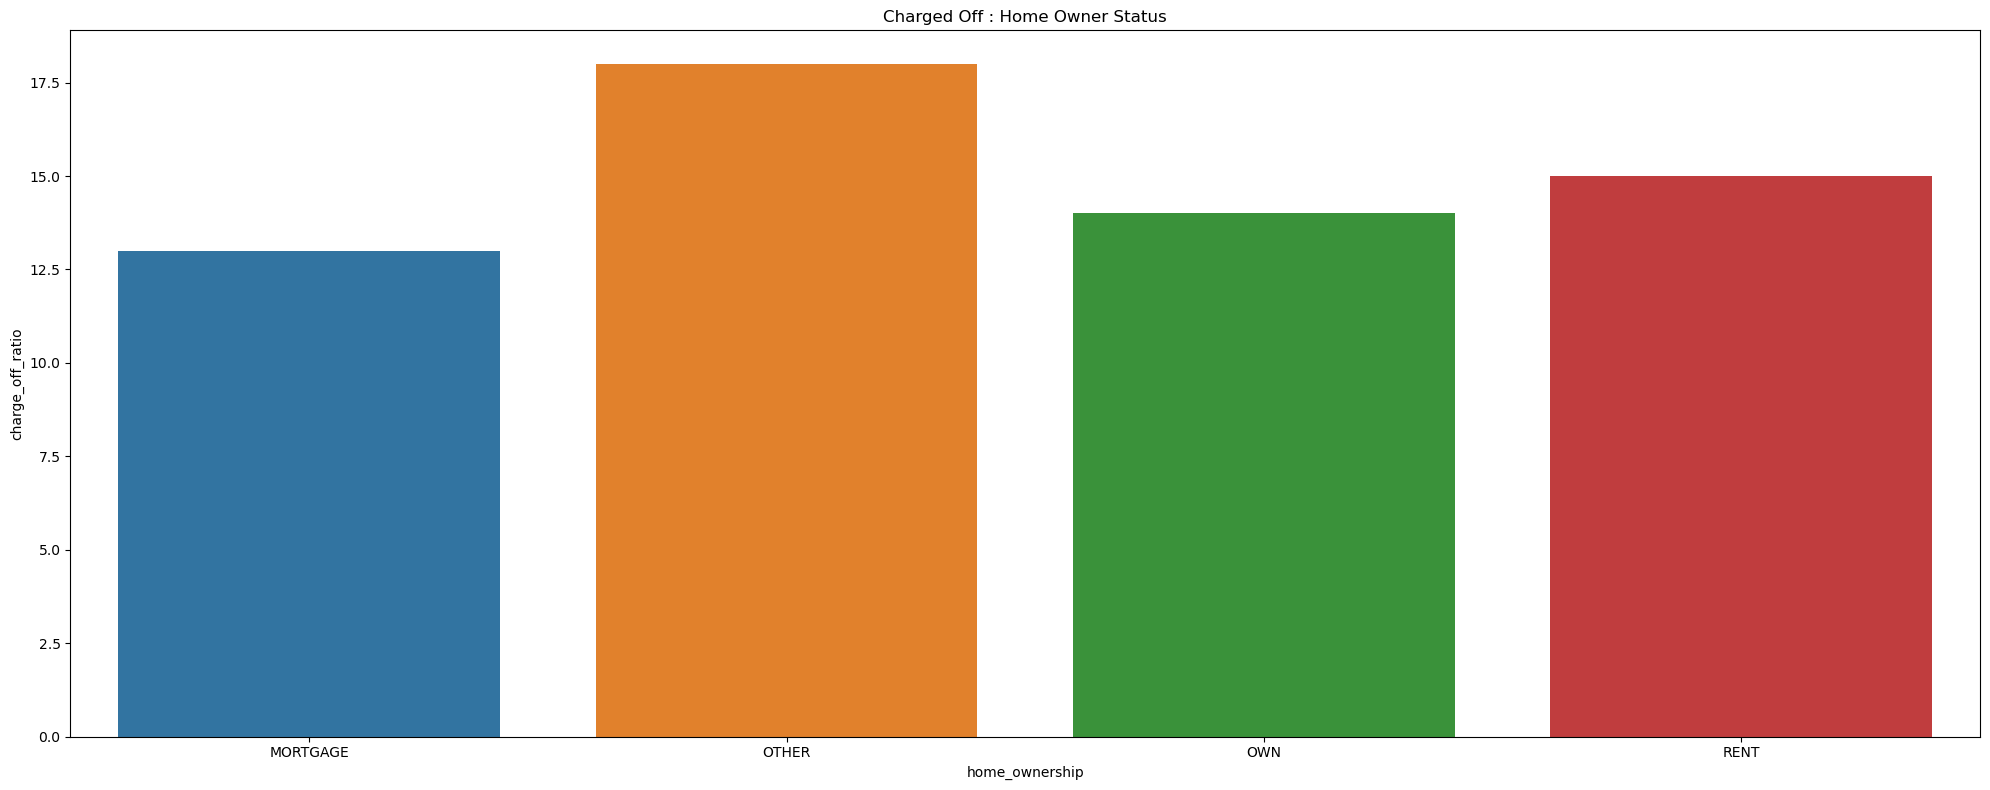

loan_status,home_ownership,Charged Off,Fully Paid,total,charge_off_ratio
0,MORTGAGE,1846,12045,13891,13.0
1,OTHER,16,73,89,18.0
2,OWN,354,2113,2467,14.0
3,RENT,2484,14125,16609,15.0


In [82]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'home_ownership')

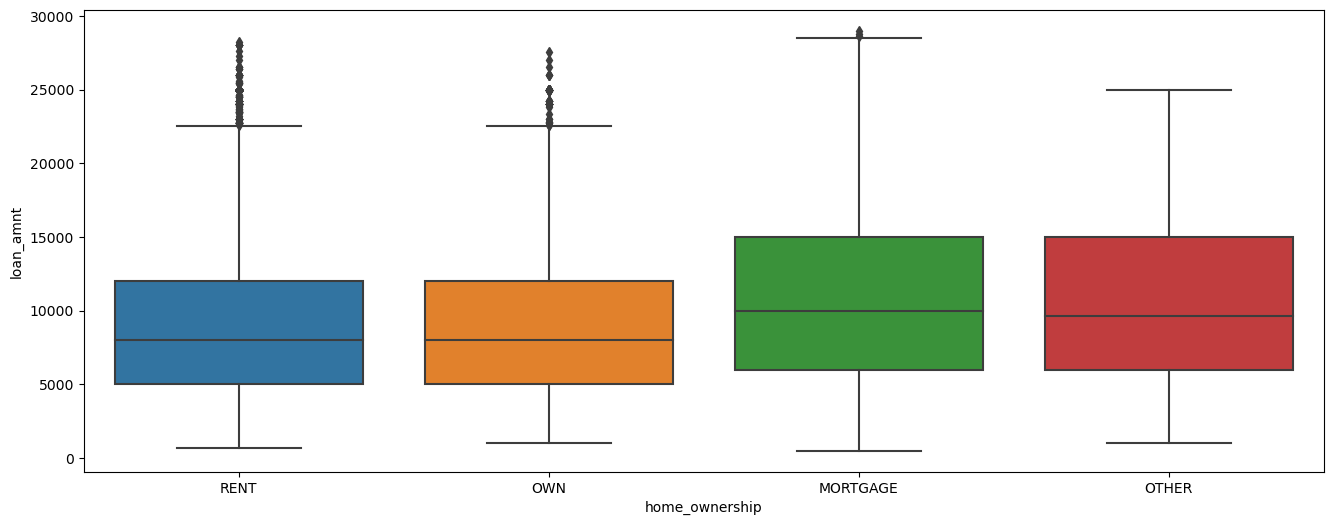

In [83]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loandf.loan_amnt,x=loandf.home_ownership)
plot.show()

***
- Overall highest Charge Off numbers are in the category of RENT and MORTGAGE
- Within each home_ownership category the ratio of Charge Off's for Other is higher
- **Inferences**
    - The home_ownership status of MORTGAGE and RENT are at the highest risk of Charge Offs
    - MORTGAGE status also has the highest range of loan amounts increasing the risk
***

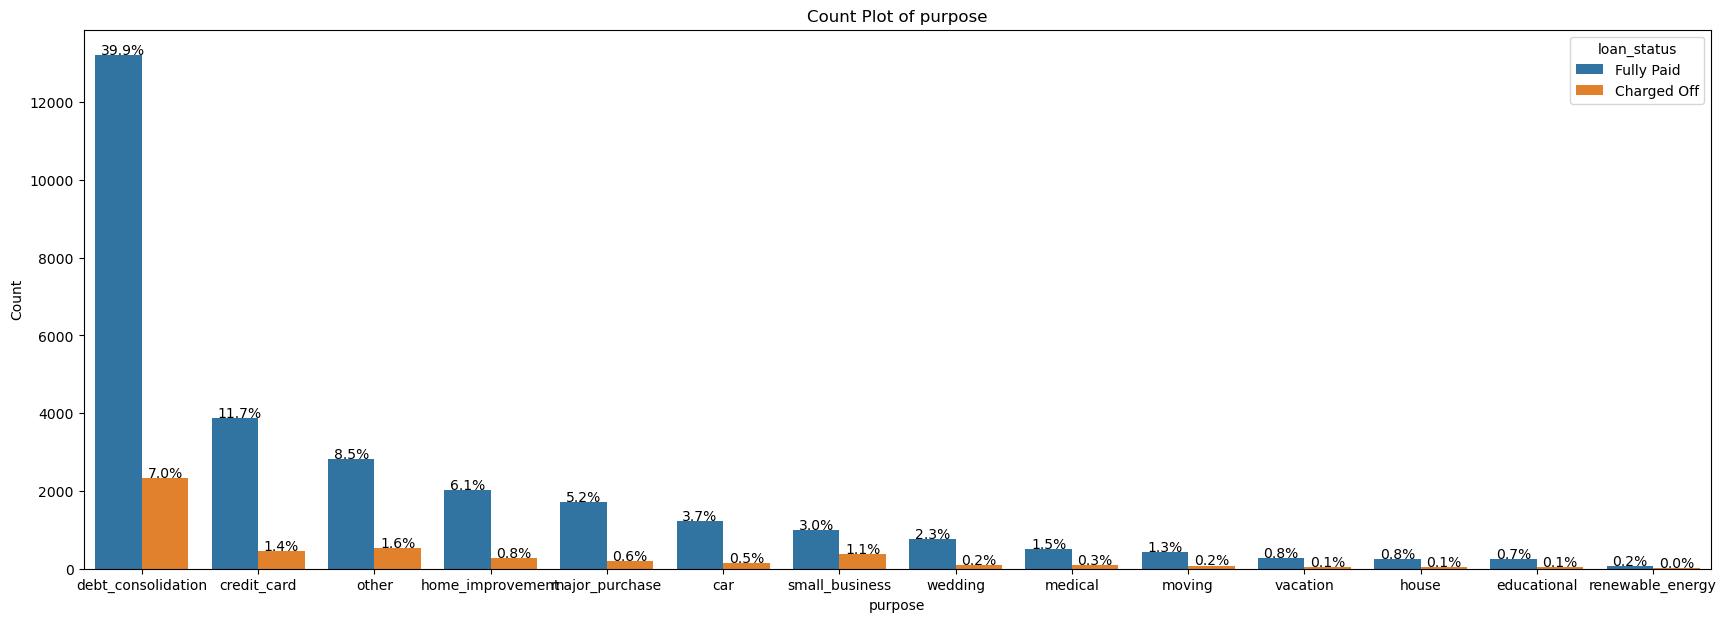

In [84]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'purpose', 'loan_status')

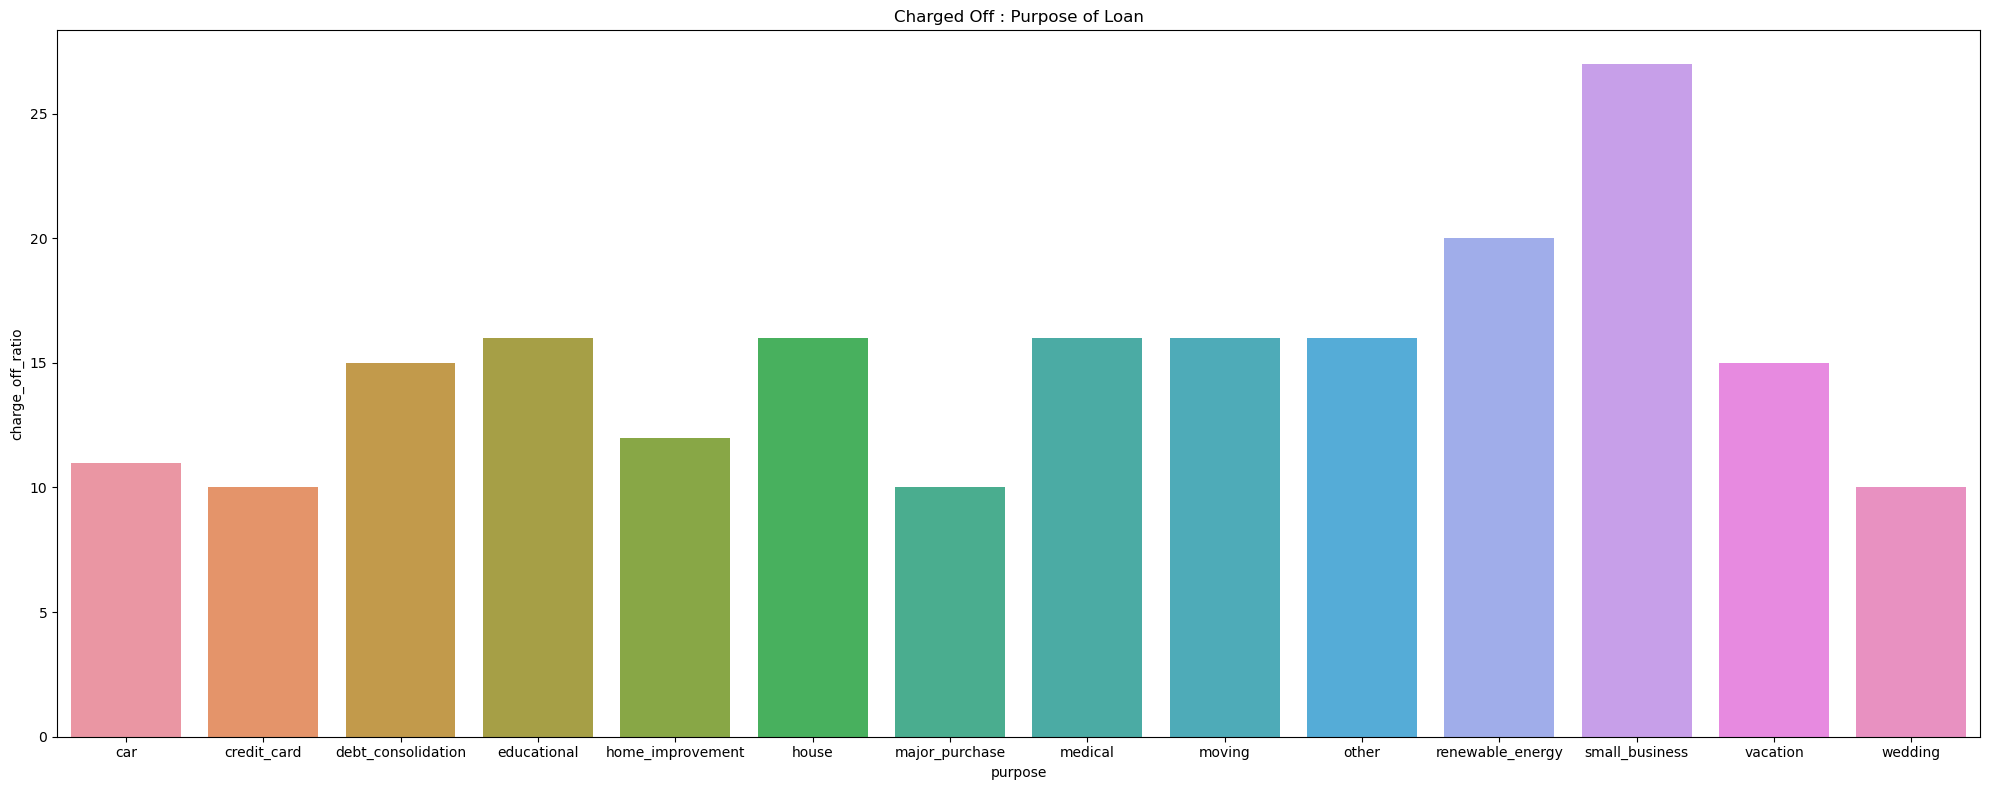

loan_status,purpose,Charged Off,Fully Paid,total,charge_off_ratio
0,car,150,1221,1371,11.0
1,credit_card,448,3868,4316,10.0
2,debt_consolidation,2325,13203,15528,15.0
3,educational,46,235,281,16.0
4,home_improvement,274,2014,2288,12.0
5,house,48,248,296,16.0
6,major_purchase,194,1710,1904,10.0
7,medical,95,509,604,16.0
8,moving,79,428,507,16.0
9,other,531,2818,3349,16.0


In [85]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'purpose')

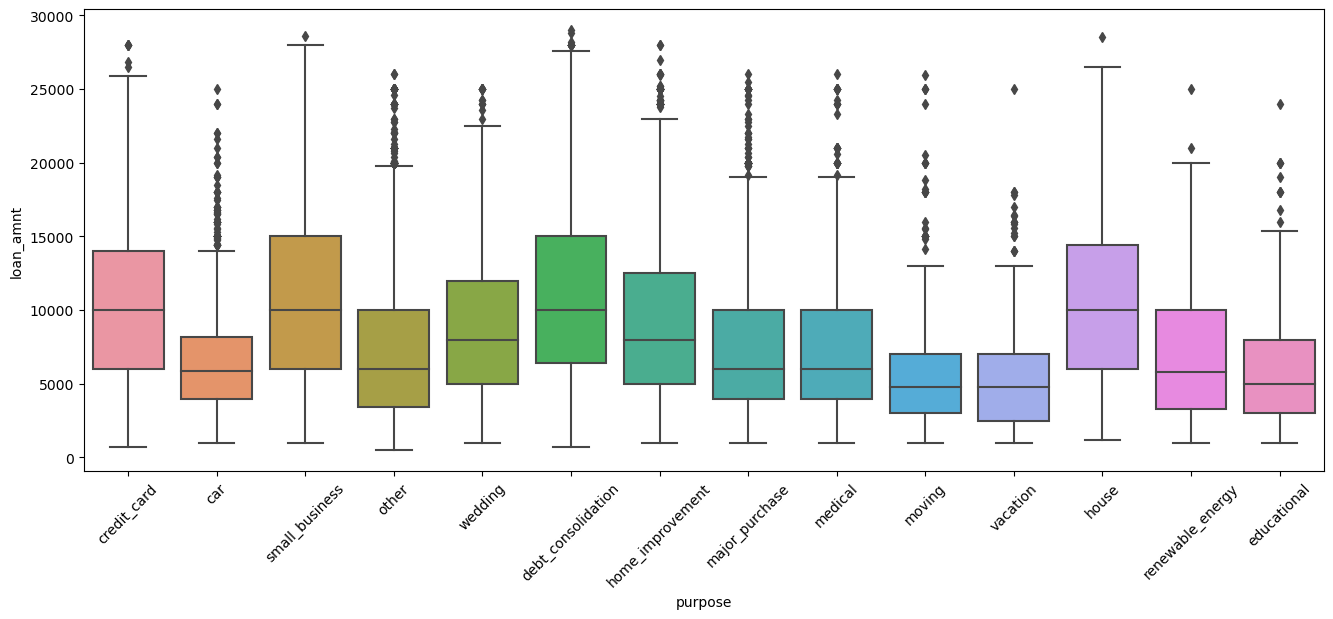

In [86]:
plot.figure(figsize=(16,6))
ax=sea.boxplot(y=loandf.loan_amnt,x=loandf.purpose)
ax.tick_params(axis='x', rotation=45)
plot.show()


***
- Highest risk of Charge Offs are the category of debt_consolidation
- Highest probablity of Charge Offs within a category are small_business but the volume is extremely low
- Highest loan amount ranges are in small business, debt consolidation and house
- **Inferences**
    - Highest risk of Charge Off's are the purpose of debt_consolidation
    - Small Business applicants have high chances of getting charged off.
    - renewable_energy has lowest risk of Charge Off's in volume
***

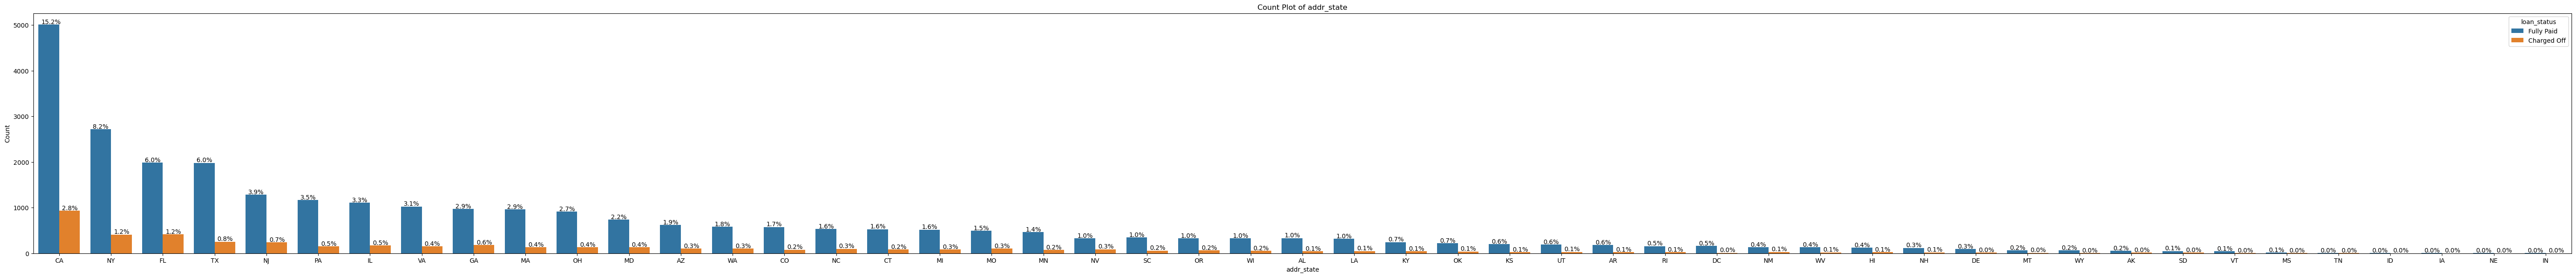

In [87]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'addr_state', 'loan_status')

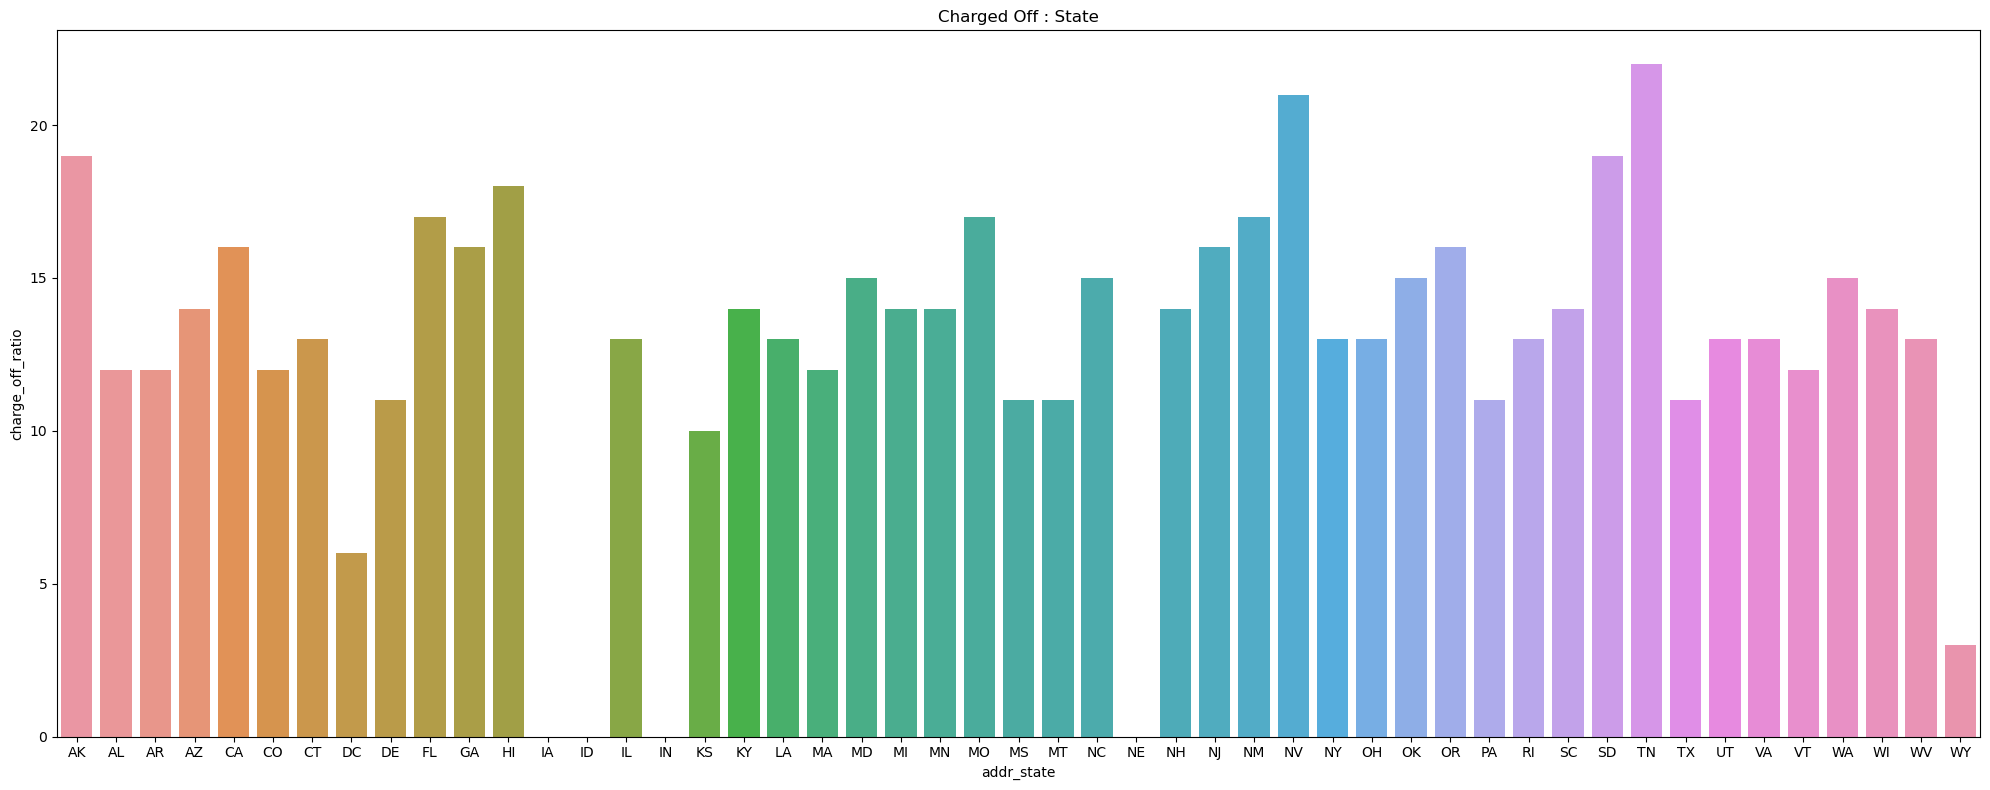

loan_status,addr_state,Charged Off,Fully Paid,total,charge_off_ratio
0,AK,12.0,51.0,63.0,19.0
1,AL,45.0,330.0,375.0,12.0
2,AR,25.0,183.0,208.0,12.0
3,AZ,103.0,618.0,721.0,14.0
4,CA,930.0,5009.0,5939.0,16.0
5,CO,77.0,576.0,653.0,12.0
6,CT,80.0,526.0,606.0,13.0
7,DC,10.0,162.0,172.0,6.0
8,DE,11.0,90.0,101.0,11.0
9,FL,413.0,1984.0,2397.0,17.0


In [88]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'addr_state')

***
- Highest volume of loans is from CA and purely based on volumes the hoghest Charge Off's are from CA
- Within each state NE and NV has the highest Charge Offs
- NE has very low volume this cannot be considered
- Loan applications from NV will have high risk
- **Inferences**
    - Loan applications from NV (Neveda) have high risk of Charge Offs
    - NV & TN has very high probablity of Charge Offs. Volume too low
    - NV,CA and TN have high percentage of Charge Off's
***

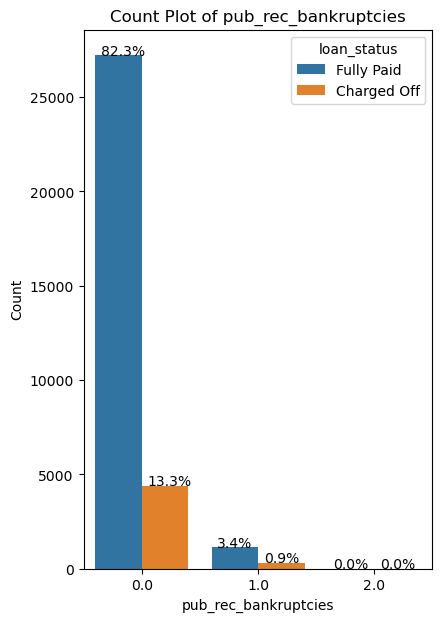

In [89]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'pub_rec_bankruptcies', 'loan_status')

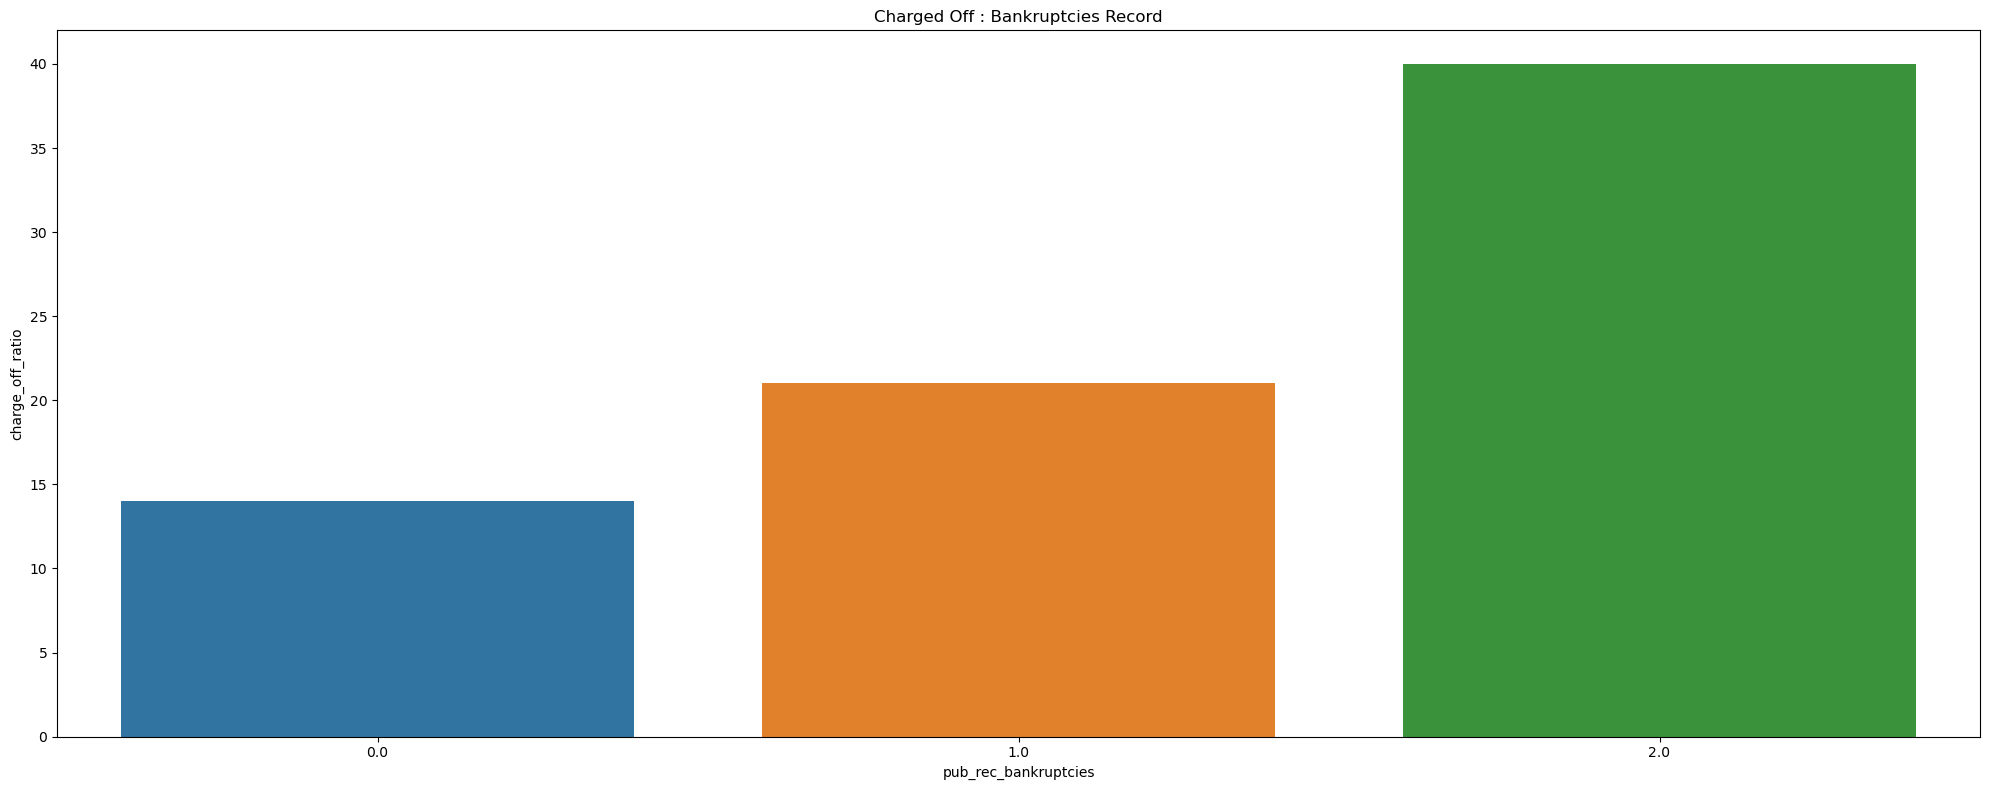

loan_status,pub_rec_bankruptcies,Charged Off,Fully Paid,total,charge_off_ratio
0,0.0,4390,27216,31606,14.0
1,1.0,308,1137,1445,21.0
2,2.0,2,3,5,40.0


In [90]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'pub_rec_bankruptcies')

***
 - Purely based on volumes the number of charge_offs are in the category of 0 (no bankruptcy record)
 - Looking at ratios within each category, customers having bankruptcy record has high charge_off ratio
 - **Inferences**
    - Customers having bankruptcy record are at high risk of Charge Offs
    - pub_rec_bankruptcies count 2 has even higher Charge Off ratio
***

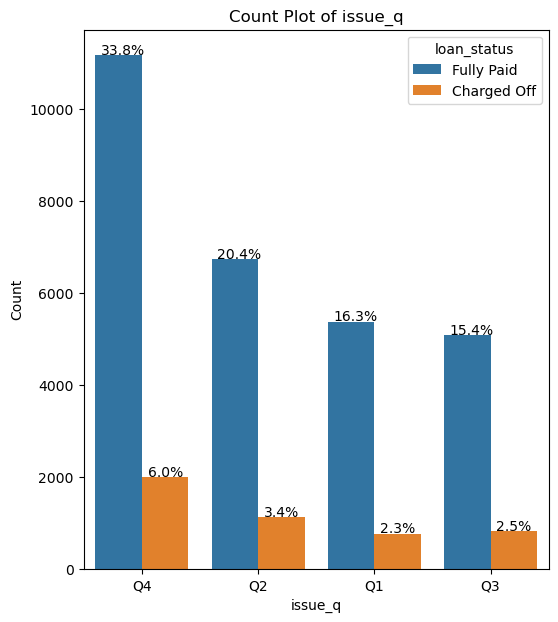

In [91]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'issue_q', 'loan_status')

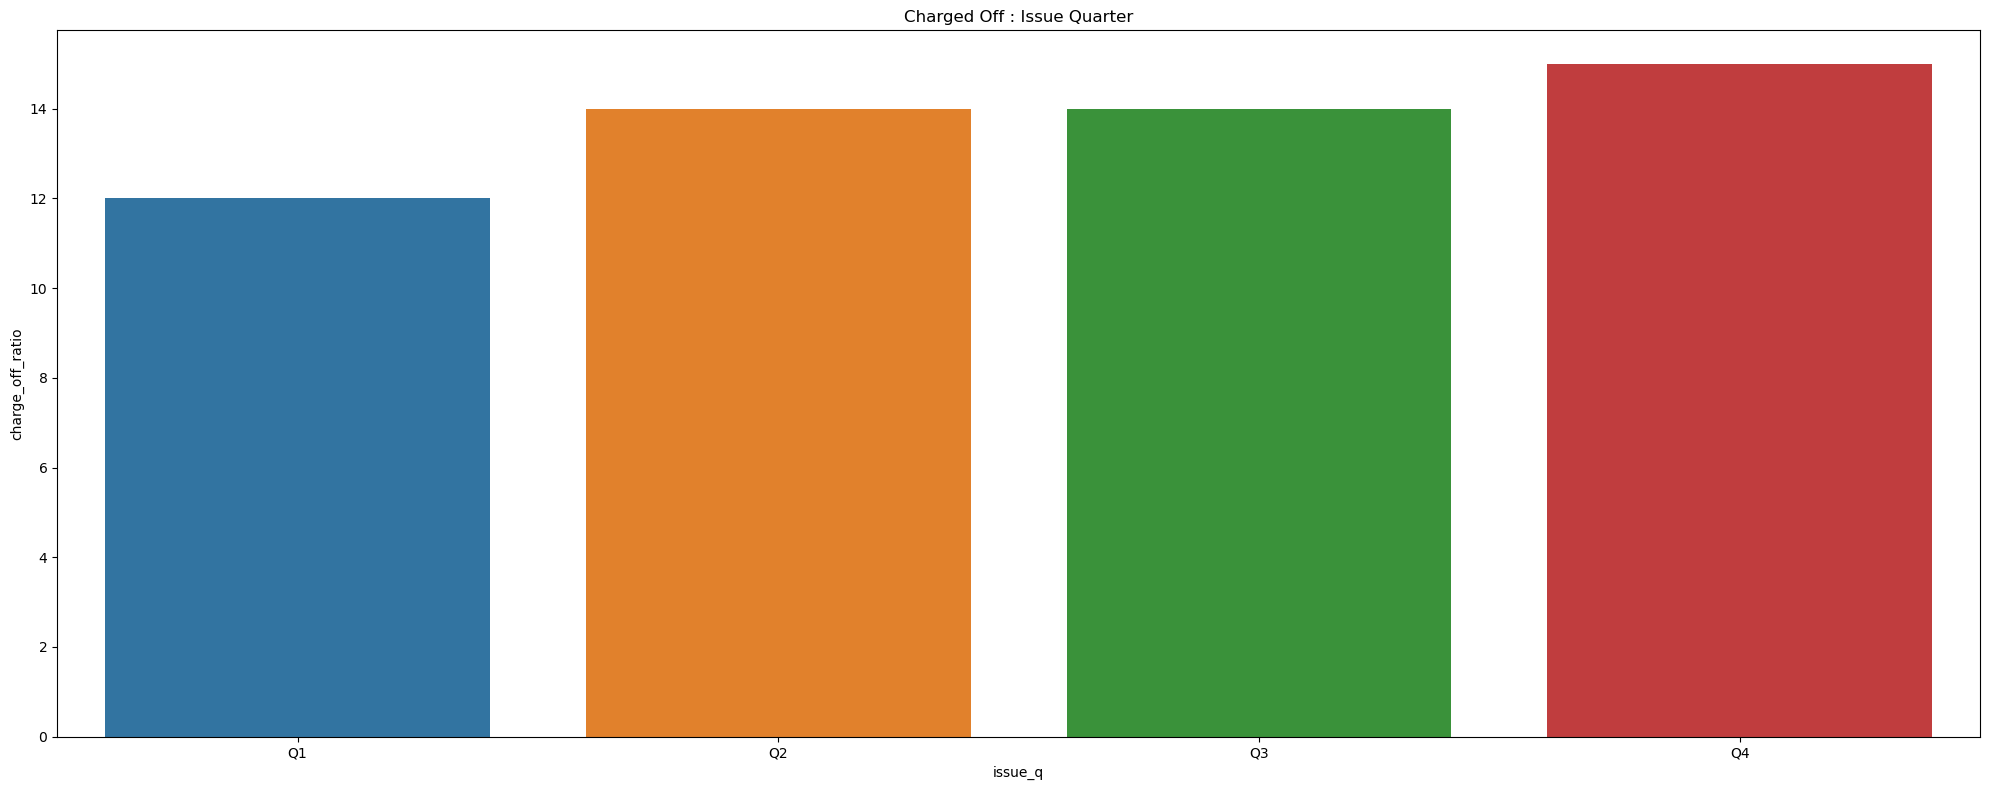

loan_status,issue_q,Charged Off,Fully Paid,total,charge_off_ratio
0,Q1,761,5376,6137,12.0
1,Q2,1124,6728,7852,14.0
2,Q3,818,5078,5896,14.0
3,Q4,1997,11174,13171,15.0


In [92]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'issue_q')

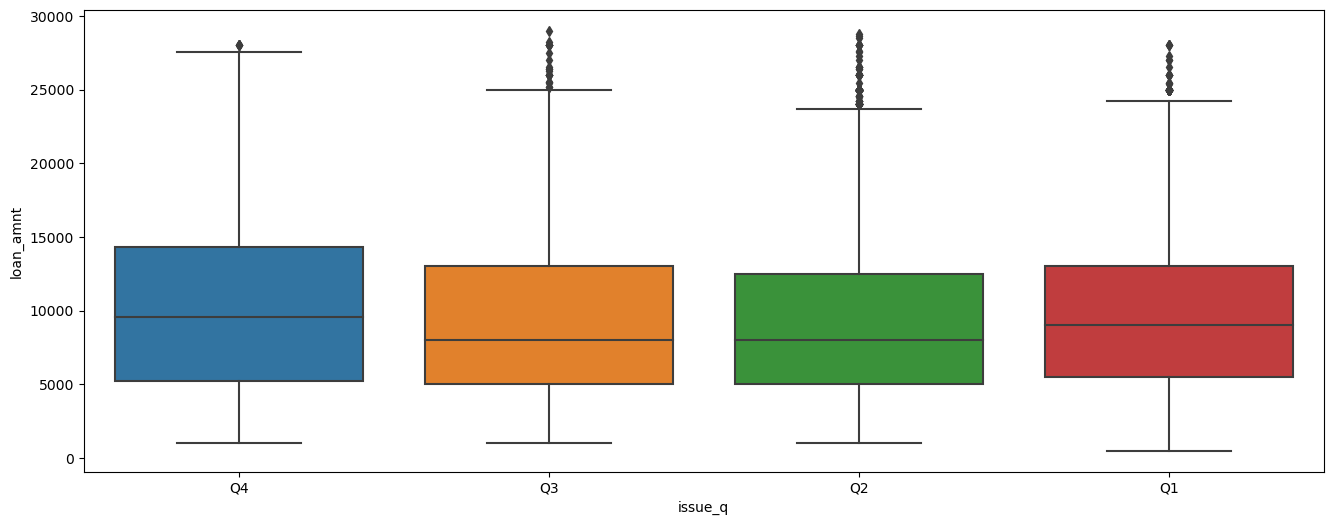

In [93]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loandf.loan_amnt,x=loandf.issue_q)
plot.show()

***
- Quarter 4 has the highest ratio of Charge Offs
- Year has no significant impact as apart from volume increasing year over year, which is impacting charge offs
- 2007 has the maximum Charge Offs. Any current loan running, which started in 2007 may have risk
- **Inferences**
    - Q4 of the year has the highest Charge Off's
    - Charge Off's will increase year over year as the loan volume increases
***

### Annual Income Bucket (annual_inc_b)

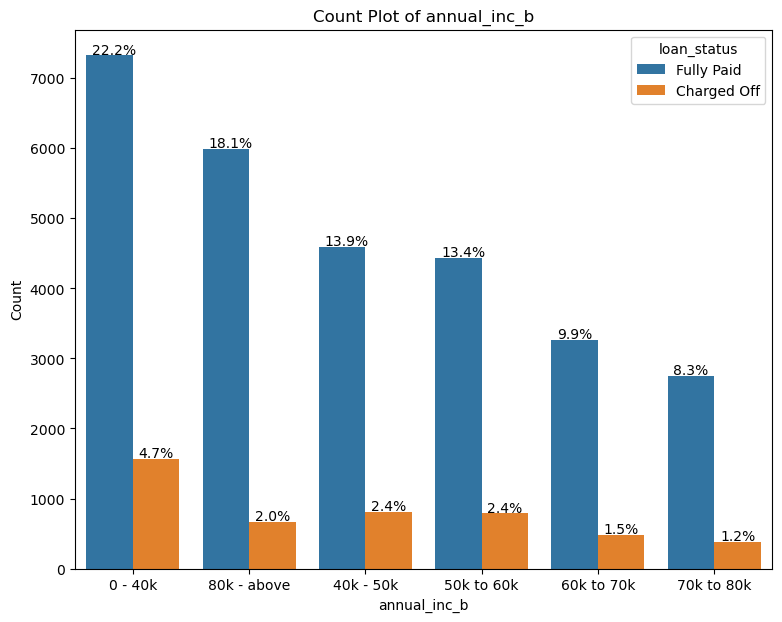

In [94]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'annual_inc_b', 'loan_status')

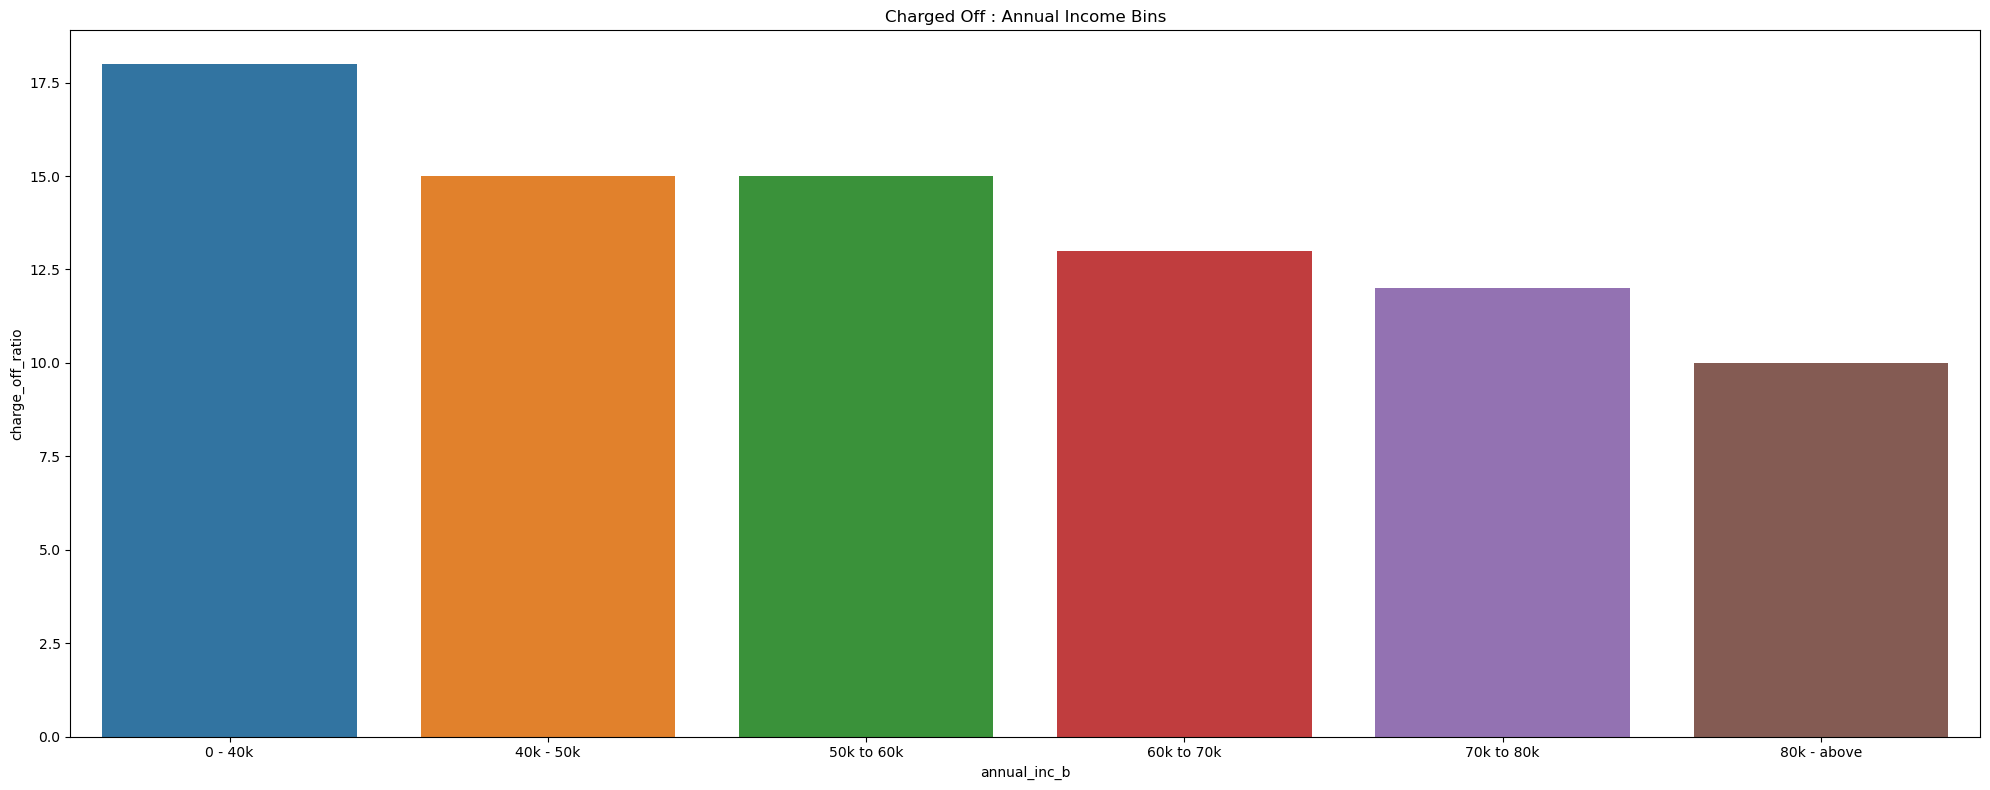

loan_status,annual_inc_b,Charged Off,Fully Paid,total,charge_off_ratio
0,0 - 40k,1570,7326,8896,18.0
1,40k - 50k,807,4593,5400,15.0
2,50k to 60k,788,4435,5223,15.0
3,60k to 70k,486,3261,3747,13.0
4,70k to 80k,385,2749,3134,12.0
5,80k - above,664,5992,6656,10.0


In [95]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'annual_inc_b')

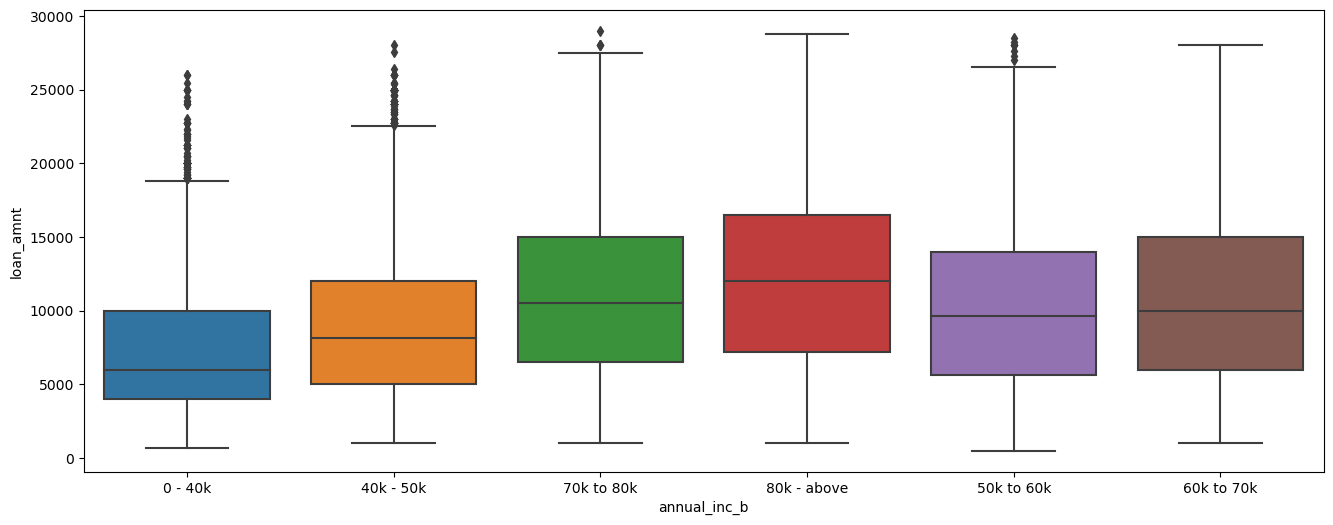

In [96]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loandf.loan_amnt,x=loandf.annual_inc_b)
plot.show()

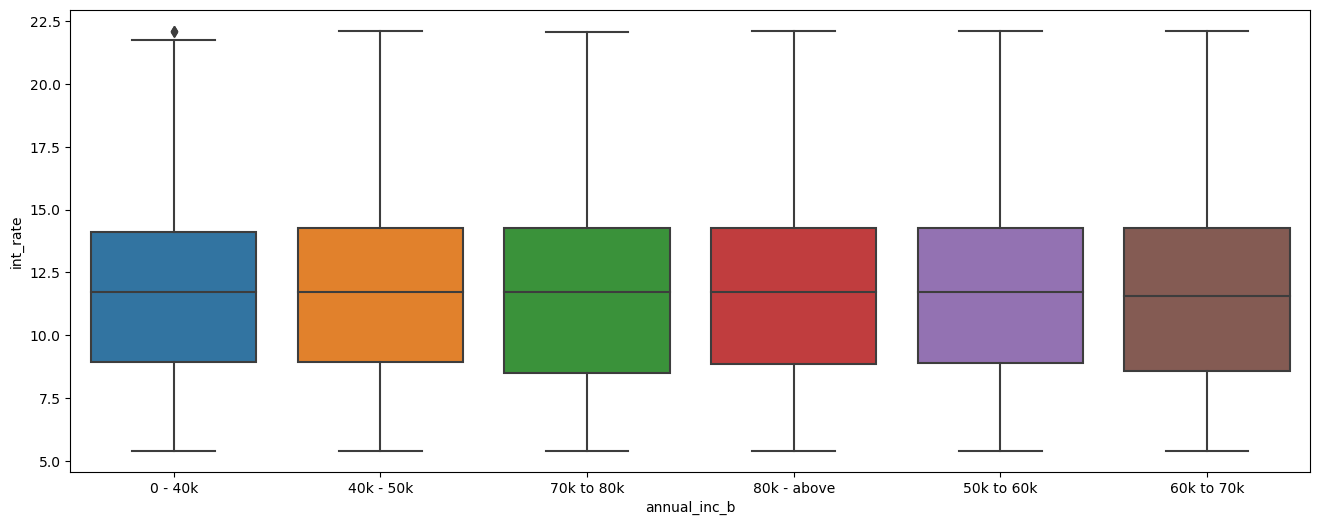

In [97]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loandf.int_rate,x=loandf.annual_inc_b)
plot.show()

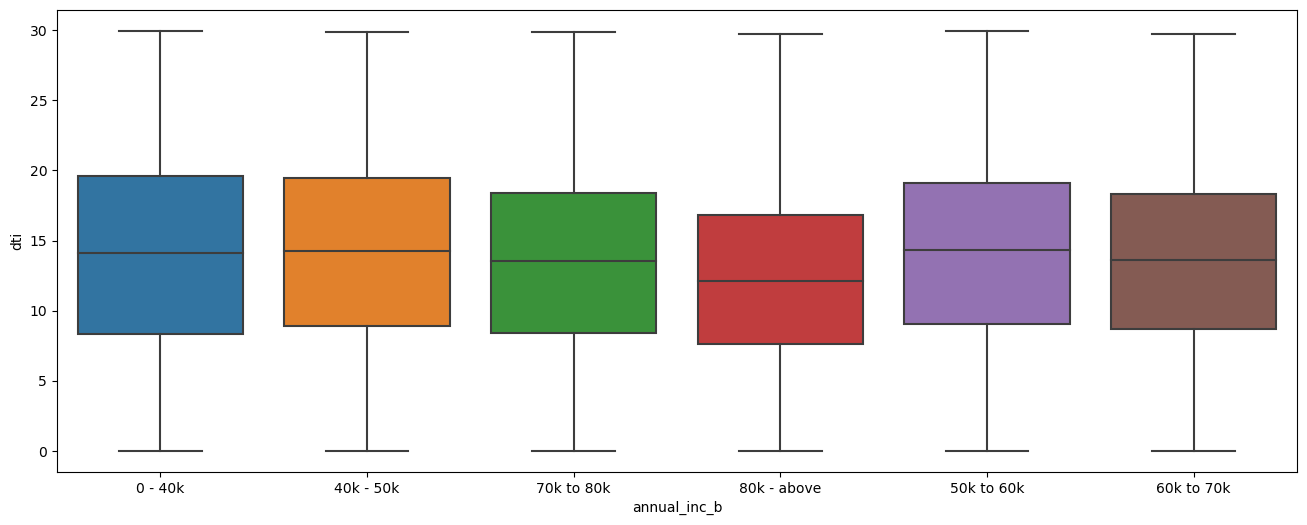

In [98]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loandf.dti,x=loandf.annual_inc_b)
plot.show()

***
- Annual income range of 0-40K has the highest charge offs
- Charge off ratio within the bucket of 0-40K have highest Charge Offs
- **Inferences**
    - Income range of 0-40K have the highest risk
    - Income range 80000+  has less chances of charged off.
    - Increase in annual income charged off proportion decreases. 
***

### Loan Amount Bucket (loan_amnt_b)

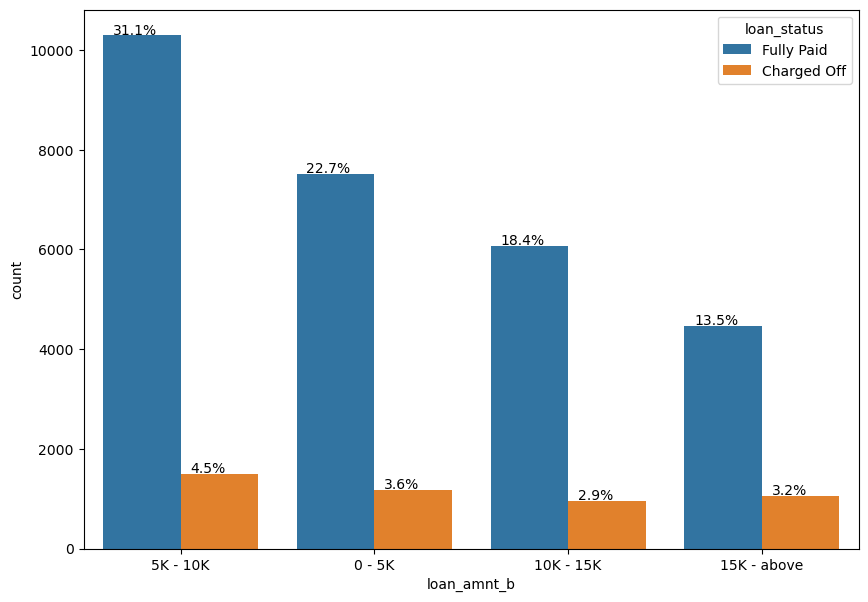

In [99]:
# Overall ratio of Charge Offs against the total
series_plot(loandf, 'loan_amnt_b', 'loan_status')

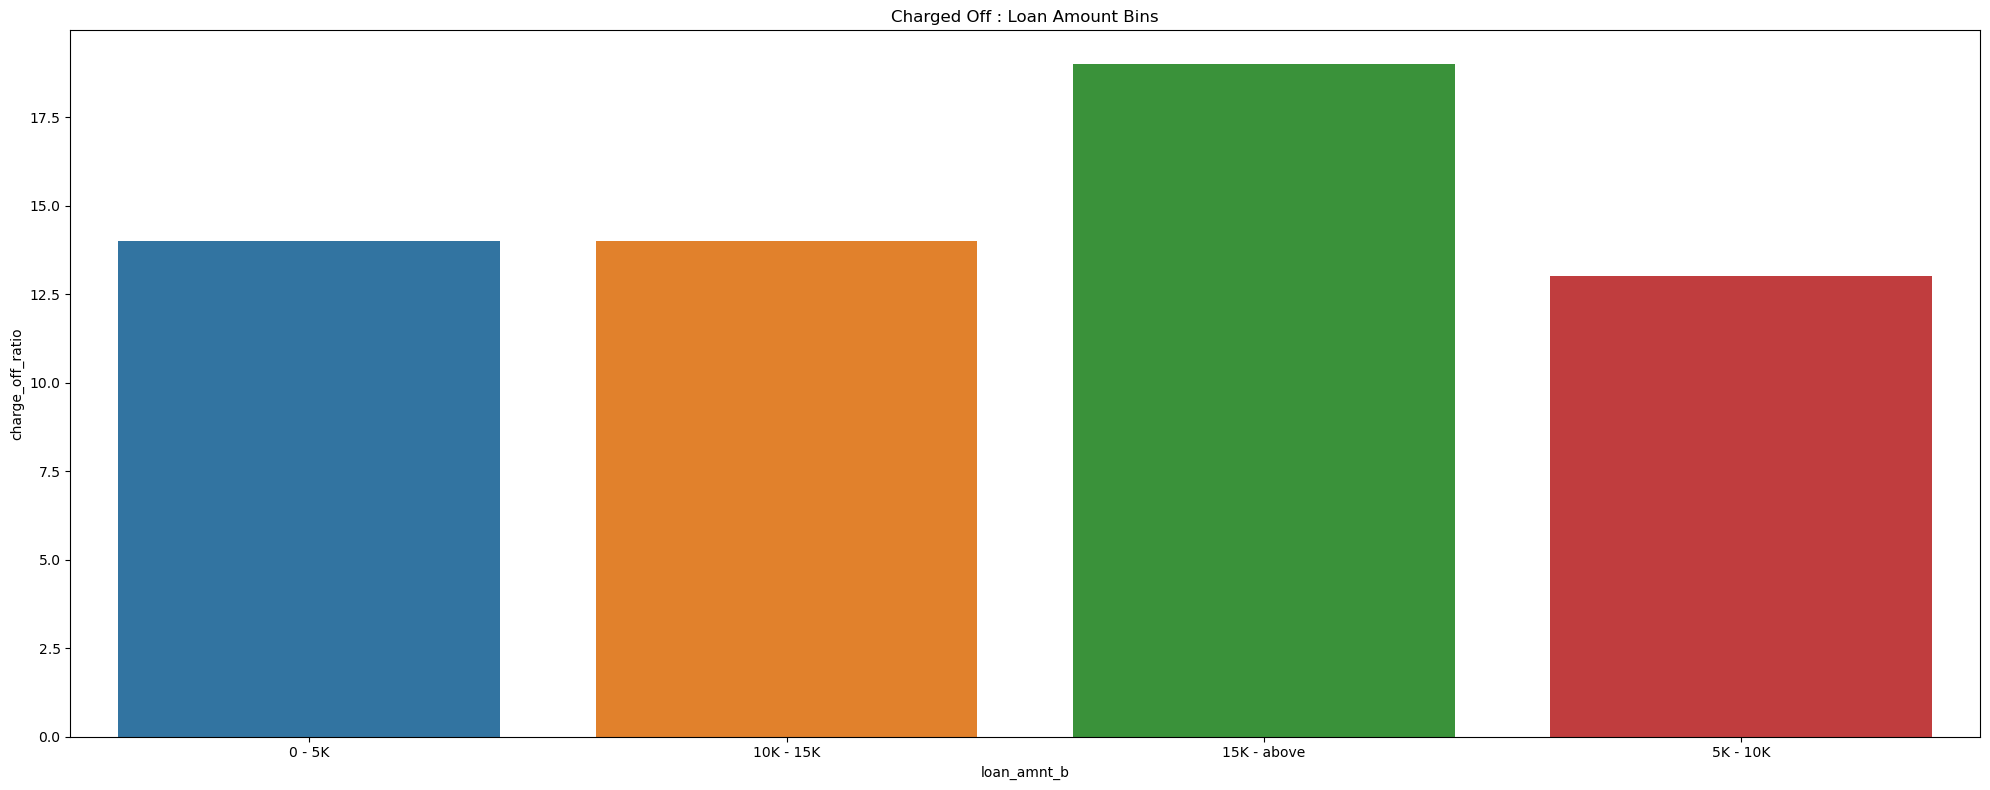

loan_status,loan_amnt_b,Charged Off,Fully Paid,total,charge_off_ratio
0,0 - 5K,1180,7520,8700,14.0
1,10K - 15K,954,6077,7031,14.0
2,15K - above,1063,4466,5529,19.0
3,5K - 10K,1503,10293,11796,13.0


In [100]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'loan_amnt_b')

***
- Based on volume highest percentage of Charge Offs are in the category of 5K to 10k of loan_ammount
- The Charge Off ratio of all the customer;s within the loan_amount of 15K and above is at the highest CHarge Off risk
- **Inferences**
    - Charge Off risk of loan amount 15K and above is at the highest risk
***

### Interest Rate Bucket (int_rate_b)

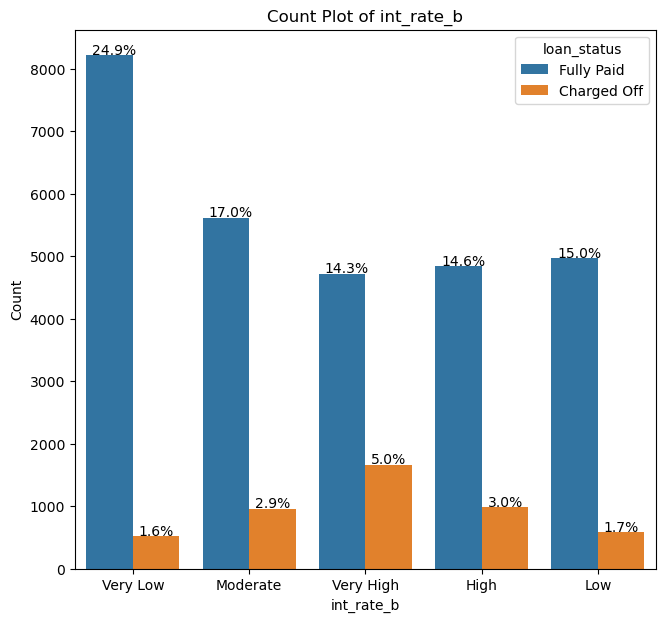

In [101]:
# Overall ratio of Charge Offs against the total
series_plot_1(loandf, 'int_rate_b', 'loan_status')

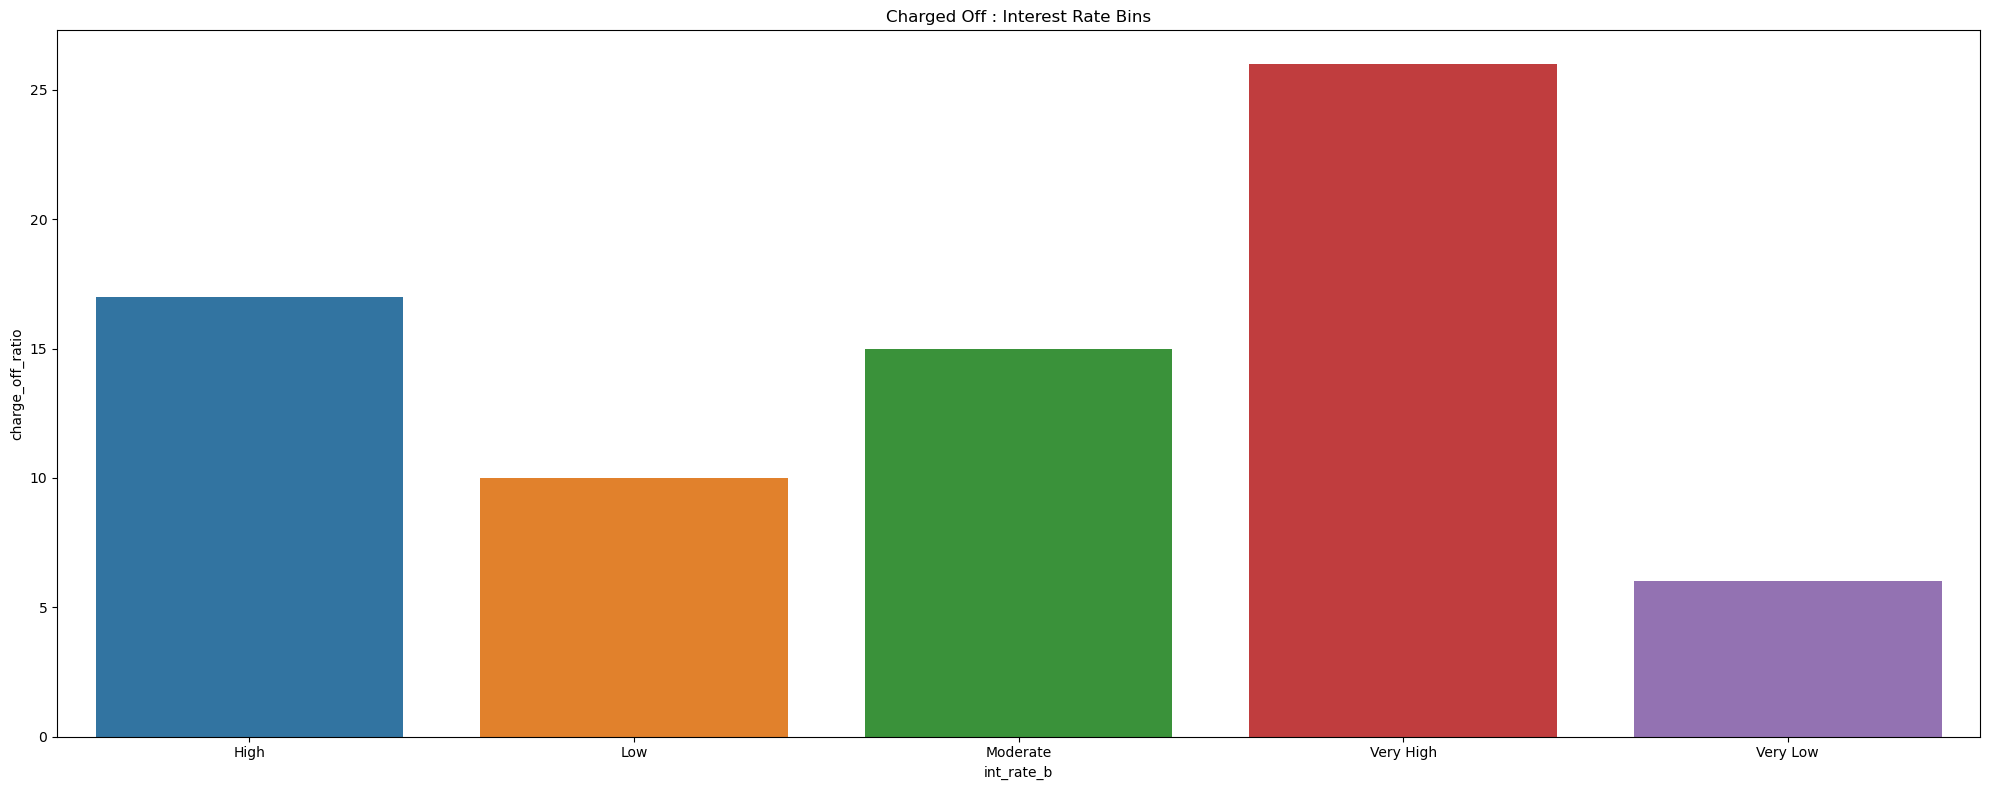

loan_status,int_rate_b,Charged Off,Fully Paid,total,charge_off_ratio
0,High,981,4837,5818,17.0
1,Low,578,4964,5542,10.0
2,Moderate,958,5618,6576,15.0
3,Very High,1665,4721,6386,26.0
4,Very Low,518,8216,8734,6.0


In [102]:
## The ratio of Charge Offs within the category total
ratio_wise_plot(loandf, 'int_rate_b')

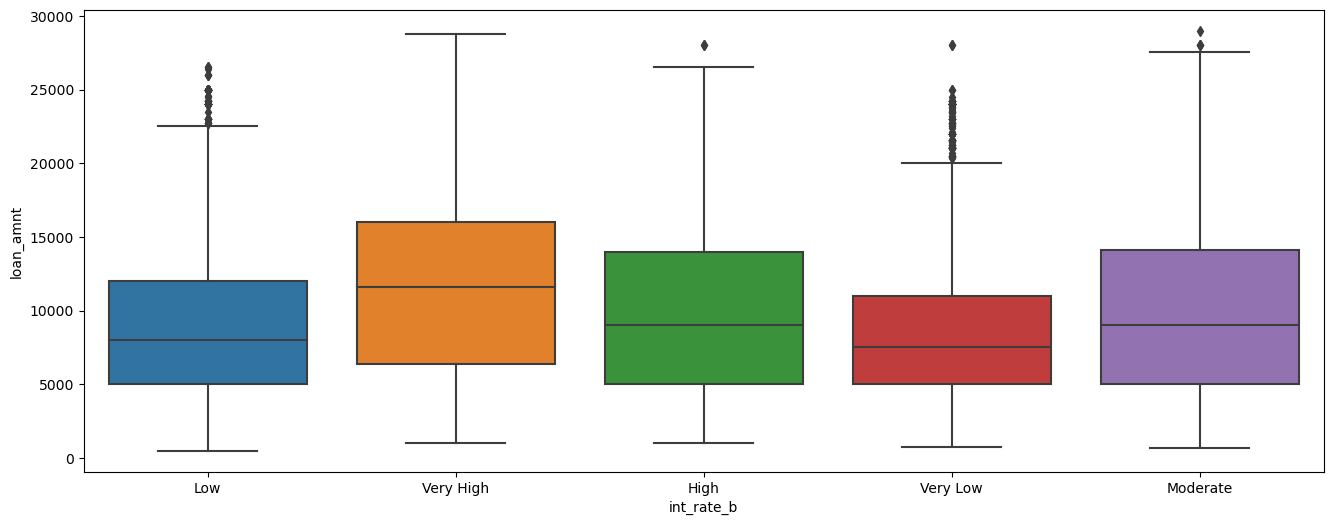

In [103]:
plot.figure(figsize=(16,6))
sea.boxplot(y=loandf.loan_amnt,x=loandf.int_rate_b)
plot.show()

***
- Based on volume and based on Charge Off ratio within the category, the Very High interest rates are in risk of Charge Off
- Very High interest rate is 15% and above
***

### Correlation Analysis

In [104]:
numeric_cols = [col for col in loandf.select_dtypes(include=[np.number]).columns.tolist() if col != 'id']
numeric_cols

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'pub_rec_bankruptcies',
 'issue_y',
 'issue_m']

In [113]:
# Define the correlation matrix
corr_matrix = loandf[numeric_cols].corr()

# Initialize empty lists to store the variables with different correlation strengths
strong_positive_corr_vars = []
positive_corr_vars = []
weak_positive_corr_vars = []
weak_corr_vars = []
weak_negative_corr_vars = []
negative_corr_vars = []
strong_negative_corr_vars = []

# Iterate over the upper triangle of the correlation matrix (excluding the diagonal)
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        # Get the correlation coefficient
        corr_coef = corr_matrix.iloc[i, j]
        # Check the correlation strength and direction
        if corr_coef > 0.9:  # strong positive correlation
            strong_positive_corr_vars.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        elif corr_coef > 0.7:  # positive correlation
            positive_corr_vars.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        elif corr_coef > 0.3:  # weak positive correlation
            weak_positive_corr_vars.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        elif abs(corr_coef) < 0.3:  # weak correlation
            weak_corr_vars.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        elif corr_coef < -0.3:  # weak negative correlation
            weak_negative_corr_vars.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        elif corr_coef < -0.7:  # negative correlation
            negative_corr_vars.append((corr_matrix.columns[i], corr_matrix.columns[j]))
        elif corr_coef < -0.9:  # strong negative correlation
            strong_negative_corr_vars.append((corr_matrix.columns[i], corr_matrix.columns[j]))

# Print the variables with different correlation strengths
print("Strong Positive Correlations:")
print(strong_positive_corr_vars)
print("Positive Correlations:")
print(positive_corr_vars)
print("Weak Positive Correlations:")
print(weak_positive_corr_vars)
print("Weak Correlations:")
print(weak_corr_vars)
print("Weak Negative Correlations:")
print(weak_negative_corr_vars)
print("Negative Correlations:")
print(negative_corr_vars)
print("Strong Negative Correlations:")
print(strong_negative_corr_vars)

Strong Positive Correlations:
[('loan_amnt', 'funded_amnt'), ('loan_amnt', 'funded_amnt_inv'), ('loan_amnt', 'installment'), ('funded_amnt', 'funded_amnt_inv'), ('funded_amnt', 'installment'), ('funded_amnt_inv', 'installment')]
Positive Correlations:
[]
Weak Positive Correlations:
[('loan_amnt', 'term'), ('loan_amnt', 'annual_inc'), ('funded_amnt', 'term'), ('funded_amnt', 'annual_inc'), ('funded_amnt_inv', 'term'), ('funded_amnt_inv', 'annual_inc'), ('term', 'int_rate'), ('installment', 'annual_inc')]
Weak Correlations:
[('loan_amnt', 'int_rate'), ('loan_amnt', 'emp_length'), ('loan_amnt', 'dti'), ('loan_amnt', 'pub_rec_bankruptcies'), ('loan_amnt', 'issue_y'), ('loan_amnt', 'issue_m'), ('funded_amnt', 'int_rate'), ('funded_amnt', 'emp_length'), ('funded_amnt', 'dti'), ('funded_amnt', 'pub_rec_bankruptcies'), ('funded_amnt', 'issue_y'), ('funded_amnt', 'issue_m'), ('funded_amnt_inv', 'int_rate'), ('funded_amnt_inv', 'emp_length'), ('funded_amnt_inv', 'dti'), ('funded_amnt_inv', 'pub_

In [117]:
import pandas as pd

def analyze_correlations(df, numeric_cols, strong_pos_thresh=0.7, 
                         pos_thresh=0.5, weak_pos_thresh=0.3, weak_corr_thresh=0.1,
                         weak_neg_thresh=-0.01, neg_thresh=-0.5, strong_neg_thresh=-0.7):
  """
  Analyzes correlations between numerical features in a DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame containing the data.
      numeric_cols (list): List of column names representing numerical features.
      strong_pos_thresh (float, optional): Threshold for strong positive correlation. Defaults to 0.7.
      pos_thresh (float, optional): Threshold for positive correlation. Defaults to 0.5.
      weak_pos_thresh (float, optional): Threshold for weak positive correlation. Defaults to 0.3.
      weak_corr_thresh (float, optional): Threshold for weak correlation (considered negligible). Defaults to 0.1.
      weak_neg_thresh (float, optional): Threshold for weak negative correlation. Defaults to -0.3.
      neg_thresh (float, optional): Threshold for negative correlation. Defaults to -0.5.
      strong_neg_thresh (float, optional): Threshold for strong negative correlation. Defaults to -0.7.

  Returns:
      dict: A dictionary containing lists of variable pairs categorized by correlation strength.
  """

  # Calculate correlation matrix
  corr_matrix = df[numeric_cols].corr()

  # Initialize empty dictionaries to store variable pairs
  correlations = {
      "Strong Positive": [],
      "Positive": [],
      "Weak Positive": [],
      "Weak Correlation": [],
      "Weak Negative": [],
      "Negative": [],
      "Strong Negative": [],
  }

  # Iterate over the upper triangle of the correlation matrix
  for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
      # Get the correlation coefficient
      corr_coef = corr_matrix.iloc[i, j]

      # Categorize correlations based on thresholds
      if abs(corr_coef) > strong_pos_thresh:
        category = "Strong Positive" if corr_coef > 0 else "Strong Negative"
      elif abs(corr_coef) > pos_thresh:
        category = "Positive" if corr_coef > 0 else "Negative"
      elif abs(corr_coef) > weak_pos_thresh:
        category = "Weak Positive" if corr_coef > 0 else "Weak Negative"
      elif abs(corr_coef) > weak_corr_thresh:
        category = "Weak Correlation"
      else:
        continue  # Skip negligible correlations

      correlations[category].append((corr_matrix.columns[i], corr_matrix.columns[j]))

  return correlations



correlations = analyze_correlations(loandf, numeric_cols)

# Print results
for category, var_pairs in correlations.items():
  if var_pairs:
    print(f"\n{category}:")
    for var1, var2 in var_pairs:
      print(f"{var1} - {var2} ({corr_matrix.loc[var1, var2]:.2f})")



Strong Positive:
loan_amnt - funded_amnt (0.98)
loan_amnt - funded_amnt_inv (0.94)
loan_amnt - installment (0.92)
funded_amnt - funded_amnt_inv (0.97)
funded_amnt - installment (0.95)
funded_amnt_inv - installment (0.91)

Weak Positive:
loan_amnt - term (0.36)
loan_amnt - annual_inc (0.34)
funded_amnt - term (0.34)
funded_amnt - annual_inc (0.33)
funded_amnt_inv - term (0.36)
funded_amnt_inv - annual_inc (0.32)
term - int_rate (0.42)
installment - annual_inc (0.33)

Weak Correlation:
loan_amnt - int_rate (0.23)
loan_amnt - emp_length (0.13)
funded_amnt - int_rate (0.24)
funded_amnt - emp_length (0.13)
funded_amnt_inv - int_rate (0.24)
funded_amnt_inv - emp_length (0.14)
funded_amnt_inv - issue_y (0.20)
term - issue_y (0.21)
int_rate - installment (0.21)
int_rate - dti (0.10)
installment - emp_length (0.10)
emp_length - annual_inc (0.19)
emp_length - issue_y (0.11)


In [122]:
import pandas as pd

def analyze_correlations(df, numeric_cols, thresh_config):
    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr()

    # Initialize empty dictionaries to store variable pairs
    correlations = {category: [] for category in thresh_config}

    # Iterate over the upper triangle of the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            # Get the correlation coefficient
            corr_coef = corr_matrix.iloc[i, j]

            # Categorize correlations based on thresholds
            for category, thresh in thresh_config.items():
                if category == "Strong Positive" and corr_coef > thresh:
                    correlations[category].append((corr_matrix.columns[i], corr_matrix.columns[j], corr_coef))
                elif category == "Positive" and corr_coef > thresh_config["Strong Positive"] and corr_coef <= thresh:
                    correlations[category].append((corr_matrix.columns[i], corr_matrix.columns[j], corr_coef))
                elif category == "Weak Positive" and corr_coef > 0 and corr_coef <= thresh:
                    correlations[category].append((corr_matrix.columns[i], corr_matrix.columns[j], corr_coef))
                elif category == "Weak Correlation" and corr_coef > thresh_config["Weak Positive"] and corr_coef <= thresh:
                    correlations[category].append((corr_matrix.columns[i], corr_matrix.columns[j], corr_coef))
                elif category == "Weak Negative" and corr_coef < 0 and corr_coef >= thresh:
                    correlations[category].append((corr_matrix.columns[i], corr_matrix.columns[j], corr_coef))
                elif category == "Negative" and corr_coef < thresh_config["Weak Negative"] and corr_coef >= thresh:
                    correlations[category].append((corr_matrix.columns[i], corr_matrix.columns[j], corr_coef))
                elif category == "Strong Negative" and corr_coef < thresh:
                    correlations[category].append((corr_matrix.columns[i], corr_matrix.columns[j], corr_coef))

    return correlations



thresh_config = {
    "Strong Positive": 0.7,
    "Positive": 0.5,
    "Weak Positive": 0.4,
    "Weak Correlation": 0.1,
    "Weak Negative": -0.3,
    "Negative": -0.5,
    "Strong Negative": -0.7
}

correlations = analyze_correlations(loandf, numeric_cols, thresh_config)

# Print results
for category, var_pairs in correlations.items():
    if var_pairs:
        print(f"\n{category}:")
        for var1, var2, corr_coef in var_pairs:
            print(f"{var1} - {var2} ({corr_coef:.2f})")

   


Strong Positive:
loan_amnt - funded_amnt (0.98)
loan_amnt - funded_amnt_inv (0.94)
loan_amnt - installment (0.92)
funded_amnt - funded_amnt_inv (0.97)
funded_amnt - installment (0.95)
funded_amnt_inv - installment (0.91)

Weak Positive:
loan_amnt - term (0.36)
loan_amnt - int_rate (0.23)
loan_amnt - emp_length (0.13)
loan_amnt - annual_inc (0.34)
loan_amnt - dti (0.09)
loan_amnt - issue_y (0.07)
loan_amnt - issue_m (0.04)
funded_amnt - term (0.34)
funded_amnt - int_rate (0.24)
funded_amnt - emp_length (0.13)
funded_amnt - annual_inc (0.33)
funded_amnt - dti (0.09)
funded_amnt - issue_y (0.09)
funded_amnt - issue_m (0.03)
funded_amnt_inv - term (0.36)
funded_amnt_inv - int_rate (0.24)
funded_amnt_inv - emp_length (0.14)
funded_amnt_inv - annual_inc (0.32)
funded_amnt_inv - dti (0.10)
funded_amnt_inv - issue_y (0.20)
funded_amnt_inv - issue_m (0.05)
term - installment (0.08)
term - emp_length (0.10)
term - annual_inc (0.06)
term - dti (0.08)
term - pub_rec_bankruptcies (0.02)
term - iss

In [105]:

#corr_loan = [col for col in df.select_dtypes(include=[np.number]).columns.tolist() ]
#corr_loan = loandf[['loan_amnt', 'term', 'int_rate', 'annual_inc','emp_length','pub_rec_bankruptcies','dti','int_rate']].copy()

In [106]:
# Printing column info to analyse missing values, empty values in a column
#corr_loan

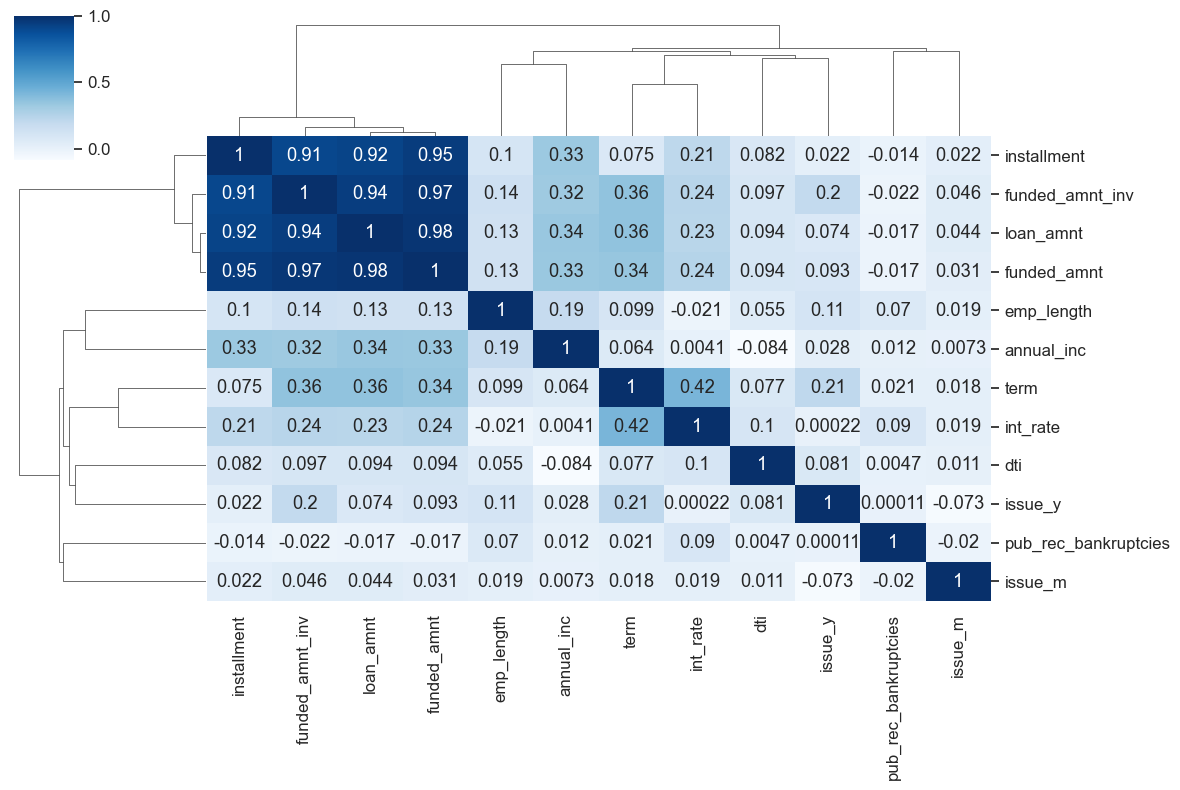

In [107]:
# Data-Cleanning
# Dropping redundant fields related to the 'loan_amnt'. They show high correlation in the corr-matrix
# Dropping fields id which do not contribute to analysis
# Dropping fields issue_y and issue_m


corr = loandf[numeric_cols].corr()

sea.set(font_scale=1.1)
sea.clustermap(corr, annot=True, figsize=(12, 8), cmap="Blues")
plot.show()

**Negative Correlation**
- loan_amnt has negative correlation with pub_rec_bankrupticies
- annual income has a negative correlation with dti

**Strong Correlation**
- term has a strong correlation with loan amount
- term has a strong correlation with interest rate
- annual income has a strong correlation with loan_amount

**Weak Correlation**
- pub_rec_bankruptcies has weak correlation with most of the fields